---
title: "Data Analysis of AMRO registries"
date: "07/04/2023"
author: 
    name: "Rodrigo Zepeda-Tello"
    email: "rodrigo.zepeda@columbia.edu"
title-block-banner: true
toc: true
number-sections: true
format: 
  html:
    fontsize: 1.1em
    code-fold: true
    code-tools: true
    page-layout: full
    body-width: 1200px
jupyter: python3
---

In [1]:
import numpy as np
import os
import polars as pl
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
import matplotlib_inline.backend_inline
from IPython.core.display import HTML
from matplotlib.ticker import FixedLocator
import matplotlib.dates as mdates
import matplotlib.ticker as mtick
import session_info

# Context for figures in jupyter notebook
sns.set(rc={"figure.dpi":100, 'savefig.dpi':300})
sns.set_context('notebook')
sns.set_style("ticks")
matplotlib_inline.backend_inline.set_matplotlib_formats("retina")

# My obsessive brain needs centered figures:
# https://stackoverflow.com/a/66493988
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

# Due to the size of the data we are using polars not pandas
data_abm = pl.read_csv(os.path.join("data_files", "adt_location_final_NH_ALL.csv"),
                          infer_schema_length=100000, null_values=['NA','null','NaN']) 

#Process dates
data_abm = data_abm.with_columns(
    pl.col(["adt_event_date"])
        .str.strptime(pl.Date, format="%Y-%m-%d"),
    pl.col(["adt_event_time","adt_ed_admission","adt_inpatient","adt_discharge","deceased_check"])
        .str.to_datetime("%Y/%m/%d %H:%M:%S")
)

#SAY HOW MANY TIMES IT IS NOT IN THE ONE IT'S SUPPOSED TO BE
#CHECK THE TYPE OF EVENT IT IS MISATTRIBUTED
#CHECK THE ROOM AT 8PM 

# Data description

A brief overlook of the data yields the following variables: 

In [2]:
data_abm.glimpse()

Rows: 4629952
Columns: 23
$ mrn                              <i64> 1000000178, 1000000178, 1000000178, 1000000178, 1000000178, 1000000178, 1000000178, 1000000178, 1000000178, 1000000178
$ adt_care_level                   <str> Acute (Floor), Acute (Floor), Acute (Floor), Acute (Floor), Acute (Floor), Acute (Floor), Acute (Floor), Acute (Floor), Acute (Floor), Acute (Floor)
$ adt_status                       <str> Acute (Floor), Acute (Floor), Acute (Floor), Acute (Floor), Acute (Floor), Acute (Floor), Acute (Floor), Acute (Floor), Acute (Floor), Acute (Floor)
$ adt_location                     <str> MIL 5 GARDEN SOUTH, MIL 5 GARDEN SOUTH, MIL 5 GARDEN SOUTH, MIL 5 GARDEN SOUTH, MIL 5 GARDEN SOUTH, MIL 5 GARDEN SOUTH, MIL 5 GARDEN SOUTH, MIL 5 GARDEN SOUTH, MIL 5 GARDEN SOUTH, MIL 5 GARDEN SOUTH
$ adt_site                         <str> MILSTEIN HOSPITAL, MILSTEIN HOSPITAL, MILSTEIN HOSPITAL, MILSTEIN HOSPITAL, MILSTEIN HOSPITAL, MILSTEIN HOSPITAL, MILSTEIN HOSPITAL, MILSTEIN HOSPITAL, M

Get an idea of the dataset

In [153]:
data_abm.head(n=20)

mrn,adt_care_level,adt_status,adt_location,adt_site,encounter_id,adt_event_type,adt_event_time,adt_ed_admission,adt_inpatient,adt_discharge,adt_discharge_disp,room_num,site_check,frequency,adt_site_name_std,adt_site_number_std,adt_discharge_disp_code,deceased_check,adt_event_date,room_8pm,hospital_block,hospital_block_8pm,event_type_order,latest_admission,latest_discharge,previous_adt_event_type,previous_adt_event_time,room_recovered_name,location_recovered_name,block_recovered_name
i64,str,str,str,str,i64,str,datetime[μs],datetime[μs],datetime[μs],datetime[μs],str,str,str,i64,str,i64,i64,datetime[μs],date,str,str,str,i32,date,date,str,datetime[μs],str,str,str
1000000178,"""Acute (Floor)""","""Acute (Floor)""","""MIL 5 GARDEN S…","""MILSTEIN HOSPI…",138398215,"""Admission""",2021-03-17 22:43:00,2021-03-17 22:43:00,2021-03-17 22:43:00,2021-03-26 14:32:00,"""Skilled Nursin…","""MIL 5 GARDEN S…","""MILSTEIN HOSPI…",355670,"""Columbia""",1,31,null,2021-03-17,"""Not in Hospita…","""MIL 5 GARDEN S…","""Not in Hospita…",-1,2021-03-17,2021-03-26,null,null,"""MIL""","""MIL""","""MIL"""
1000000178,"""Acute (Floor)""","""Acute (Floor)""","""MIL 5 GARDEN S…","""MILSTEIN HOSPI…",138398215,"""Patient Update…",2021-03-17 22:53:00,2021-03-17 22:43:00,2021-03-17 22:43:00,2021-03-26 14:32:00,"""Skilled Nursin…","""MIL 5 GARDEN S…","""MILSTEIN HOSPI…",355670,"""Columbia""",1,31,null,2021-03-17,"""Not in Hospita…","""MIL 5 GARDEN S…","""Not in Hospita…",0,2021-03-17,2021-03-26,"""Admission""",2021-03-17 22:43:00,"""MIL""","""MIL""","""MIL"""
1000000178,"""Acute (Floor)""","""Acute (Floor)""","""MIL 5 GARDEN S…","""MILSTEIN HOSPI…",138398215,"""Census""",2021-03-17 23:59:00,2021-03-17 22:43:00,2021-03-17 22:43:00,2021-03-26 14:32:00,"""Skilled Nursin…","""MIL 5 GARDEN S…","""MILSTEIN HOSPI…",355670,"""Columbia""",1,31,null,2021-03-17,"""Not in Hospita…","""MIL 5 GARDEN S…","""Not in Hospita…",0,2021-03-17,2021-03-26,"""Patient Update…",2021-03-17 22:53:00,"""MIL""","""MIL""","""MIL"""
1000000178,"""Acute (Floor)""","""Acute (Floor)""","""MIL 5 GARDEN S…","""MILSTEIN HOSPI…",138398215,"""Transfer Out""",2021-03-18 14:09:00,2021-03-17 22:43:00,2021-03-17 22:43:00,2021-03-26 14:32:00,"""Skilled Nursin…","""MIL 5 GARDEN S…","""MILSTEIN HOSPI…",355670,"""Columbia""",1,31,null,2021-03-18,"""MIL CARDIAC CA…","""MIL 5 GARDEN S…","""MIL CARDIAC CA…",1,2021-03-17,2021-03-26,"""Census""",2021-03-17 23:59:00,"""MIL""","""MIL""","""MIL"""
1000000178,"""Acute (Floor)""","""Acute (Floor)""","""MIL 5 GARDEN S…","""MILSTEIN HOSPI…",138398215,"""Transfer In""",2021-03-18 14:09:00,2021-03-17 22:43:00,2021-03-17 22:43:00,2021-03-26 14:32:00,"""Skilled Nursin…","""MIL CARDIAC CA…","""MILSTEIN HOSPI…",355670,"""Columbia""",1,31,null,2021-03-18,"""MIL CARDIAC CA…","""MIL 5 GARDEN S…","""MIL CARDIAC CA…",-1,2021-03-17,2021-03-26,"""Transfer Out""",2021-03-18 14:09:00,"""MIL""","""MIL""","""MIL"""
1000000178,"""Acute (Floor)""","""Acute (Floor)""","""MIL 5 GARDEN S…","""MILSTEIN HOSPI…",138398215,"""Transfer Out""",2021-03-18 23:42:00,2021-03-17 22:43:00,2021-03-17 22:43:00,2021-03-26 14:32:00,"""Skilled Nursin…","""MIL CARDIAC CA…","""MILSTEIN HOSPI…",355670,"""Columbia""",1,31,null,2021-03-18,"""MIL CARDIAC CA…","""MIL 5 GARDEN S…","""MIL CARDIAC CA…",1,2021-03-17,2021-03-26,"""Transfer In""",2021-03-18 14:09:00,"""MIL""","""MIL""","""MIL"""
1000000178,"""Acute (Floor)""","""Acute (Floor)""","""MIL 5 GARDEN S…","""MILSTEIN HOSPI…",138398215,"""Transfer In""",2021-03-18 23:42:00,2021-03-17 22:43:00,2021-03-17 22:43:00,2021-03-26 14:32:00,"""Skilled Nursin…","""MIL 5 GARDEN S…","""MILSTEIN HOSPI…",355670,"""Columbia""",1,31,null,2021-03-18,"""MIL CARDIAC CA…","""MIL 5 GARDEN S…","""MIL CARDIAC CA…",-1,2021-03-17,2021-03-26,"""Transfer Out""",2021-03-18 23:42:00,"""MIL""","""MIL""","""MIL"""
1000000178,"""Acute (Floor)""","""Acute (Floor)""","""MIL 5 GARDEN S…","""MILSTEIN HOSPI…",138398215,"""Census""",2021-03-18 23:59:00,2021-03-17 22:43:00,2021-03-17 22:43:00,2021-03-26

There are 10 variables of interest:

+ `mrn` which provides the unique patient identifier. 
+ `adt_location` which should provide the location of the patient
+ `adt_site` provides where the patient is hospitalized. 
+ `adt_event_type` provides a registry of which event is associated to the row: `Admission`, `Census`, `Transfer Out`,
`Tranfer In`, `Patient Update`, `Leave of Absence Return`, `Leave of Abscense Out`, `Discharge`, `Leave of Absence Census`.
+ `adt_event_time` the `datetime` associated with the `adt_event_type` (i.e. with the row's registry). 
+ `adt_event_date` the date associated to `adt_event_time`
+ `adt_ed_admission` a `datetime` supposedly of the time the patient was admitted (does not necesarily match with `adt_event_time`. 
+ `adt_discharge` a `datetime` supposedly of the time the patient was discharged (does not necesarily match with `adt_event_time`. 
+ `room_num` the room number
+ `deceased_check` a `datetime` if the individual died. Else it is `null`. 

In [152]:
print(f'There are {data_abm.unique("mrn").shape[0]} patients, with {data_abm.shape[0]} events ')

There are 210837 patients, with 4629952 events 


# Date validation

In this section we validate everything related to dates and times of registry. 

In [4]:
#We codify as numeric the event types so that discharges appear first, then everything else (census and such) and finally admissions
data_abm = data_abm.with_columns(
    pl.when((pl.col("adt_event_type") == "Discharge") | (pl.col("adt_event_type") == "Transfer Out"))
    .then(pl.lit(1))
    .when((pl.col("adt_event_type") == "Admission") | (pl.col("adt_event_type") == "Transfer In"))
    .then(pl.lit(-1))
    .otherwise(pl.lit(0))
    .alias("event_type_order")
)

## Event times vs admissions

Check that 
$$
\text{adt\_ed\_admission} \leq \text{adt\_event\_time}  \leq \text{adt\_discharge}
$$

In [5]:
incorrect_times = data_abm.filter((pl.col("adt_ed_admission") > pl.col("adt_event_time")) |
                                  (pl.col("adt_discharge") < pl.col("adt_event_time")))

if incorrect_times.shape[0] > 0:
    print(f"❌ There were {incorrect_times.shape[0]} values where" + 
          " 'adt_ed_admission' < 'adt_event_time' < 'adt_discharge' did not happen.")
else:
    print(f"✅ All event times (`adt_event_time`) ocurr between\nadmission (`adt_ed_admission`)and discharge (`adt_discharge`)" +
         "\nwhenever all three of these values are provided")

✅ All event times (`adt_event_time`) ocurr between
admission (`adt_ed_admission`)and discharge (`adt_discharge`)
whenever all three of these values are provided


Check that `adt_event_date` matches the date in `adt_event_time`

In [6]:
incorrect_dates = data_abm.filter(
    pl.col("adt_event_date") != pl.col("adt_event_time").cast(pl.Date))

if incorrect_dates.shape[0] > 0:
    print(f"❌ There were {incorrect_dates.shape[0]} values where" + 
          " 'adt_event_date' != 'adt_event_time'.")
else:
    print(f"✅ All event time (`adt_event_time`) have accurate dates\n(`adt_event_date`)")        

✅ All event time (`adt_event_time`) have accurate dates
(`adt_event_date`)


## Total number of registries per date

We analyze the total number of regisitries at each date to see if some dates have very low numbers. Specifically first and last dates seem to be missing data as shown in figure @fig-patients. This can also be seen in the first and last entries: 

### First dates

The first four entries for the dates show lower patient counts than usual. 

In [7]:
# Obtain unique date-mrn combinations
distinct_mrn_event = data_abm.unique(subset=["mrn", "adt_event_date"], keep="first", maintain_order=True)

# Count the combinations
count_mrn_event = distinct_mrn_event.groupby("adt_event_date", maintain_order=True).agg(pl.count())

# We can see that the first 4 dates have a very low value
count_mrn_event.sort("adt_event_date").head(n=10)

adt_event_date,count
date,u32
2020-02-01,278
2020-02-02,420
2020-02-03,623
2020-02-04,725
2020-02-05,812
2020-02-06,874
2020-02-07,918
2020-02-08,839
2020-02-09,878


### Last dates

The last entry for the dates shows a lower patient count. 

In [8]:
# The same problem happens with the last date
count_mrn_event.sort("adt_event_date").tail(n=10)

adt_event_date,count
date,u32
2023-05-12,1651
2023-05-13,1439
2023-05-14,1377
2023-05-15,1679
2023-05-16,1708
2023-05-17,1682
2023-05-18,1624
2023-05-19,1587
2023-05-20,1359


### Complete date picture

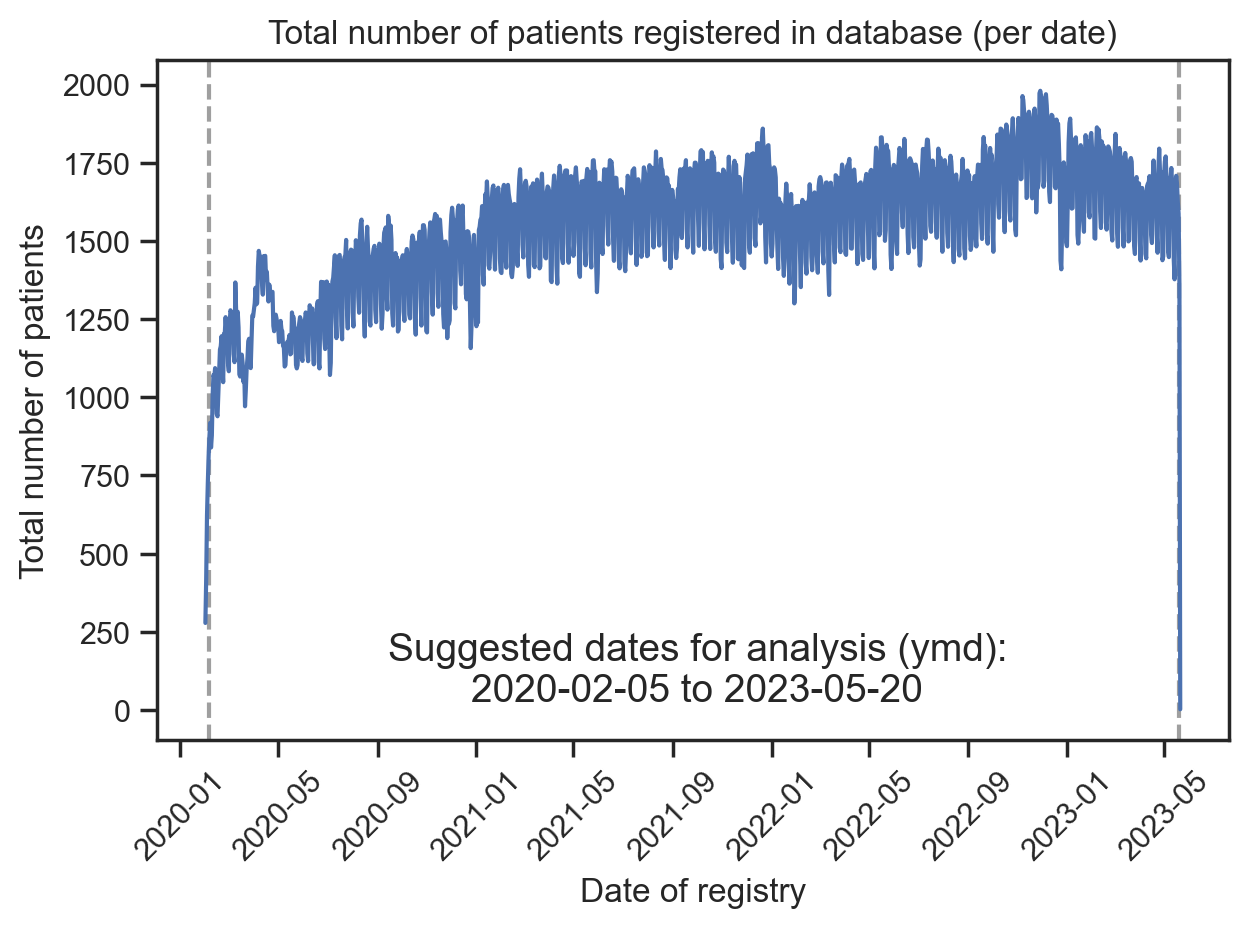

In [9]:
#| label: fig-patients
#| fig-cap: "Total number of patients reported in the database"

# Vertical line dates
init_date = dt.datetime.strptime("2020-02-05", '%Y-%m-%d').date()
end_date = dt.datetime.strptime("2023-05-20", '%Y-%m-%d').date()

#Create plot
plt.figure()
plt.axvline(x = init_date, ymin = 0, linestyle = '--', 
            alpha = 0.5, color = "#404040") 
plt.axvline(x = end_date, ymin = 0, linestyle = '--', 
            alpha = 0.5, color = "#404040") 
ax = sns.lineplot(data=count_mrn_event.to_pandas(), x="adt_event_date", y="count")
ax.set_ylabel("Total number of patients")
ax.set_xlabel("Date of registry")
textstr = "Suggested dates for analysis (ymd):\n2020-02-05 to 2023-05-20"
ax.text(dt.datetime.strptime("2021-10-01", '%Y-%m-%d'), 250, textstr, fontsize=14,
        verticalalignment='top', horizontalalignment='center')
plt.title('Total number of patients registered in database (per date)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

The same analysis stratified by hospital is shown in figure @fig-patients-hospital

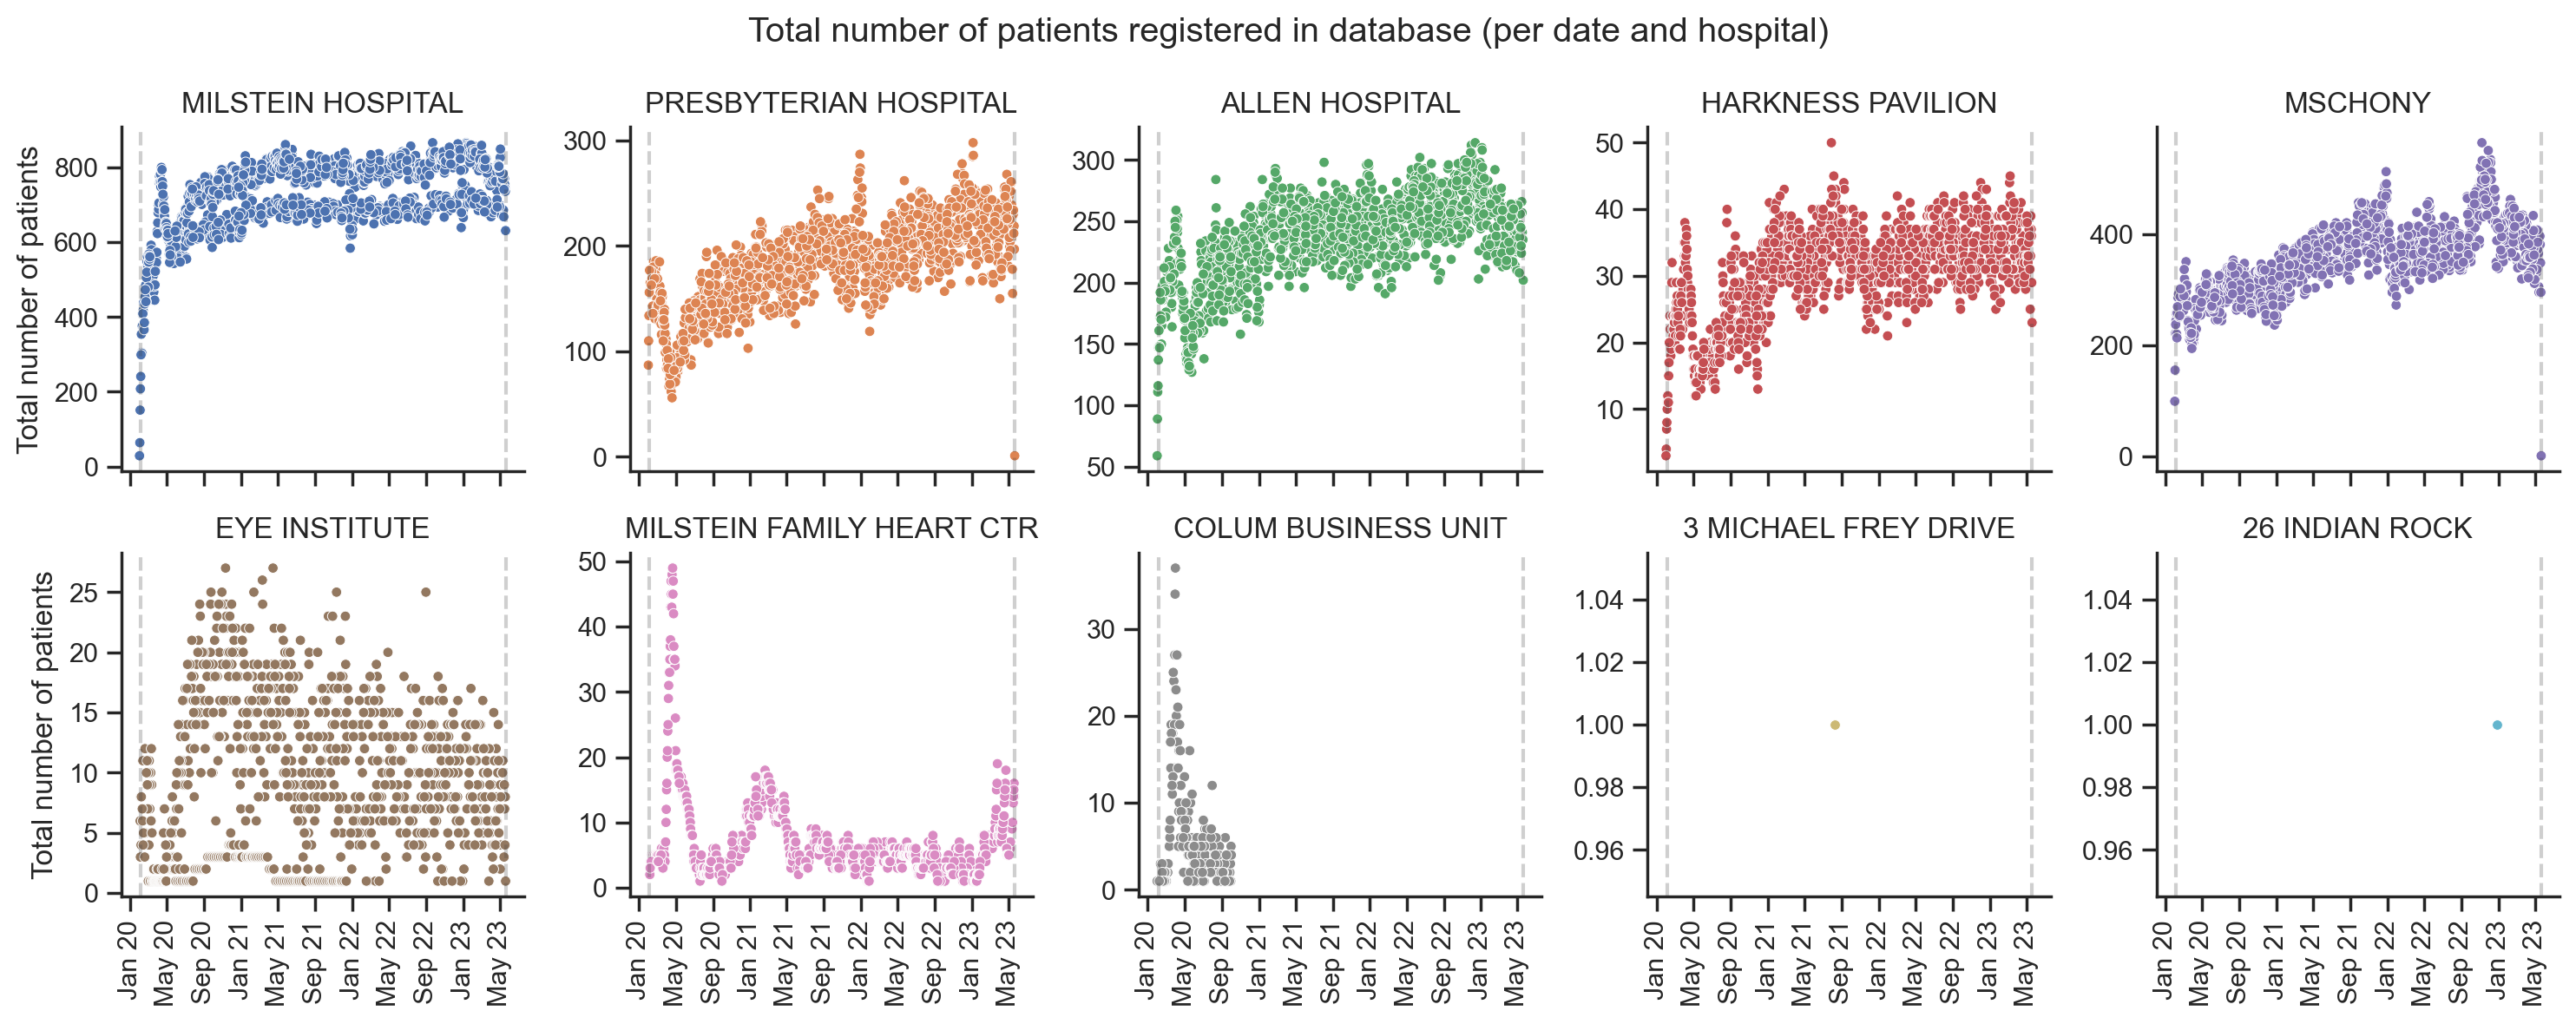

In [10]:
#| label: fig-patients-hospital
#| fig-cap: "Total number of patients reported in the database by institution `site_check`"

# Date validation (per hospital)
distinct_mrn_event_hosp = data_abm.unique(subset=["mrn", "adt_event_date","site_check"], 
                                          keep="first", maintain_order=True)

# Count the combinations
count_mrn_event_hosp = (distinct_mrn_event_hosp
                        .groupby(["adt_event_date","site_check"], maintain_order=True)
                        .agg(pl.count()))

# Plot by hospital
g = sns.FacetGrid(count_mrn_event_hosp.to_pandas(), col="site_check", hue="site_check", col_wrap=5, sharey=False)
g.map(sns.scatterplot, "adt_event_date", "count", size = 10)
g.set_axis_labels("", "Total number of patients")
g.set_titles(col_template="{col_name}", row_template="{row_name}")
g.fig.subplots_adjust(top=.9)
g.fig.suptitle('Total number of patients registered in database (per date and hospital)')

for ax in g.axes.flat:
    ax.axvline(x = init_date, ymin = 0, linestyle = '--', alpha = 0.25, color = "#404040") 
    ax.axvline(x = end_date, ymin = 0, linestyle = '--', alpha = 0.25, color = "#404040") 
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    ax.xaxis.set_major_locator(FixedLocator(ax.get_xticks()))
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %y"))

plt.tight_layout()
plt.show()

Here we can see the records from the individual at **3 MICHAEL FREY DRIVE**. They show only a discharge from the place with no admission. The date is not even close to the other emergency admissions. 

In [11]:
# Check the individuals in 3 michael frey drive
# We notice that patient was only discharged from michael frey
michael_frey = (data_abm
                .filter(pl.col("site_check") == "3 MICHAEL FREY DRIVE")
                .select("mrn")
                .item())

data_abm.filter(pl.col("mrn") == michael_frey)

mrn,adt_care_level,adt_status,adt_location,adt_site,encounter_id,adt_event_type,adt_event_time,adt_ed_admission,adt_inpatient,adt_discharge,adt_discharge_disp,room_num,site_check,frequency,adt_site_name_std,adt_site_number_std,adt_discharge_disp_code,deceased_check,adt_event_date,room_8pm,hospital_block,hospital_block_8pm,event_type_order
i64,str,str,str,str,i64,str,datetime[μs],datetime[μs],datetime[μs],datetime[μs],str,str,str,i64,str,i64,i64,datetime[μs],date,str,str,str,i32
1006607973,null,null,"""WCH 3MICH PROC…","""3 MICHAEL FREY…",152656981,"""Discharge""",2021-08-09 14:43:00,2021-08-09 00:00:00,null,2021-08-09 14:43:00,"""Home or Self C…",null,"""3 MICHAEL FREY…",null,"""Columbia""",1,15,null,2021-08-09,"""Not in Hospita…",null,"""Not in Hospita…",1
1006607973,"""Emergency""","""Emergency""","""PBY ADULT EMER…","""PRESBYTERIAN H…",178668436,"""Admission""",2021-12-30 08:39:00,2021-12-30 08:39:00,null,2021-12-30 12:11:00,"""Home or Self C…","""PBY ADULT EMER…","""PRESBYTERIAN H…",87884,"""Columbia""",1,15,null,2021-12-30,"""Not in Hospita…","""PBY ADULT EMER…","""Not in Hospita…",-1
1006607973,"""Emergency""",null,"""PBY ADULT EMER…","""PRESBYTERIAN H…",178668436,"""Discharge""",2021-12-30 12:11:00,2021-12-30 08:39:00,null,2021-12-30 12:11:00,"""Home or Self C…","""PBY ADULT EMER…","""PRESBYTERIAN H…",87884,"""Columbia""",1,15,null,2021-12-30,"""Not in Hospita…","""PBY ADULT EMER…","""Not in Hospita…",1


Here we can see the records from the individual at **26 INDIAN ROCK**. They show only a discharge from the place with no admission. The date is not even close to the other admissions. 

In [12]:
# Check the individuals in 26 indian rock
# We notice that patient was only discharged from indian rock
indian_rock = (data_abm
               .filter(pl.col("site_check") == "26 INDIAN ROCK")
               .select("mrn")
               .item())

data_abm.filter(pl.col("mrn") == indian_rock)

mrn,adt_care_level,adt_status,adt_location,adt_site,encounter_id,adt_event_type,adt_event_time,adt_ed_admission,adt_inpatient,adt_discharge,adt_discharge_disp,room_num,site_check,frequency,adt_site_name_std,adt_site_number_std,adt_discharge_disp_code,deceased_check,adt_event_date,room_8pm,hospital_block,hospital_block_8pm,event_type_order
i64,str,str,str,str,i64,str,datetime[μs],datetime[μs],datetime[μs],datetime[μs],str,str,str,i64,str,i64,i64,datetime[μs],date,str,str,str,i32
1400849869,null,null,"""RKL 26INDRK PR…","""26 INDIAN ROCK…",212948619,"""Discharge""",2022-12-28 00:04:00,2022-12-28 00:00:00,null,2022-12-28 00:04:00,"""Home or Self C…",null,"""26 INDIAN ROCK…",null,"""Columbia""",1,15,null,2022-12-28,"""Not in Hospita…",null,"""Not in Hospita…",1
1400849869,"""Acute (Floor)""","""Acute (Floor)""","""MIL 2 EP LAB""","""MILSTEIN HOSPI…",214496139,"""Admission""",2023-03-03 05:37:00,2023-03-03 05:37:00,null,2023-03-04 09:26:00,"""Home or Self C…","""MIL 2 EP LAB M…","""MILSTEIN HOSPI…",355670,"""Columbia""",1,15,null,2023-03-03,"""MIL 2 EP LAB M…","""Admitted to a …","""Admitted to a …",-1
1400849869,"""Acute (Floor)""","""Acute (Floor)""","""MIL 2 EP LAB""","""MILSTEIN HOSPI…",214496139,"""Patient Update…",2023-03-03 11:32:00,2023-03-03 05:37:00,null,2023-03-04 09:26:00,"""Home or Self C…","""MIL 2 EP LAB M…","""MILSTEIN HOSPI…",355670,"""Columbia""",1,15,null,2023-03-03,"""MIL 2 EP LAB M…","""Admitted to a …","""Admitted to a …",0
1400849869,"""Acute (Floor)""","""Acute (Floor)""","""MIL 2 EP LAB""","""MILSTEIN HOSPI…",214496139,"""Census""",2023-03-03 23:59:00,2023-03-03 05:37:00,null,2023-03-04 09:26:00,"""Home or Self C…","""MIL 2 EP LAB M…","""MILSTEIN HOSPI…",355670,"""Columbia""",1,15,null,2023-03-03,"""MIL 2 EP LAB M…","""Admitted to a …","""Admitted to a …",0
1400849869,"""Acute (Floor)""",null,"""MIL 2 EP LAB""","""MILSTEIN HOSPI…",214496139,"""Discharge""",2023-03-04 09:26:00,2023-03-03 05:37:00,null,2023-03-04 09:26:00,"""Home or Self C…","""MIL 2 EP LAB M…","""MILSTEIN HOSPI…",355670,"""Columbia""",1,15,null,2023-03-04,"""Not in Hospita…","""Admitted to a …","""Not in Hospita…",1


::: {.callout-tip title="Actions"}
### Suggested course of action

+ Remove Indian Rock and Michael Frey as they only have 1 individual (each) that was discharged. 
+ Restrict data to the period (ymd): `2020-02-05` to `2023-05-20`
+ Seek data-generators to provide an explanation for Colum Business Unit

:::

## Admissions date plots

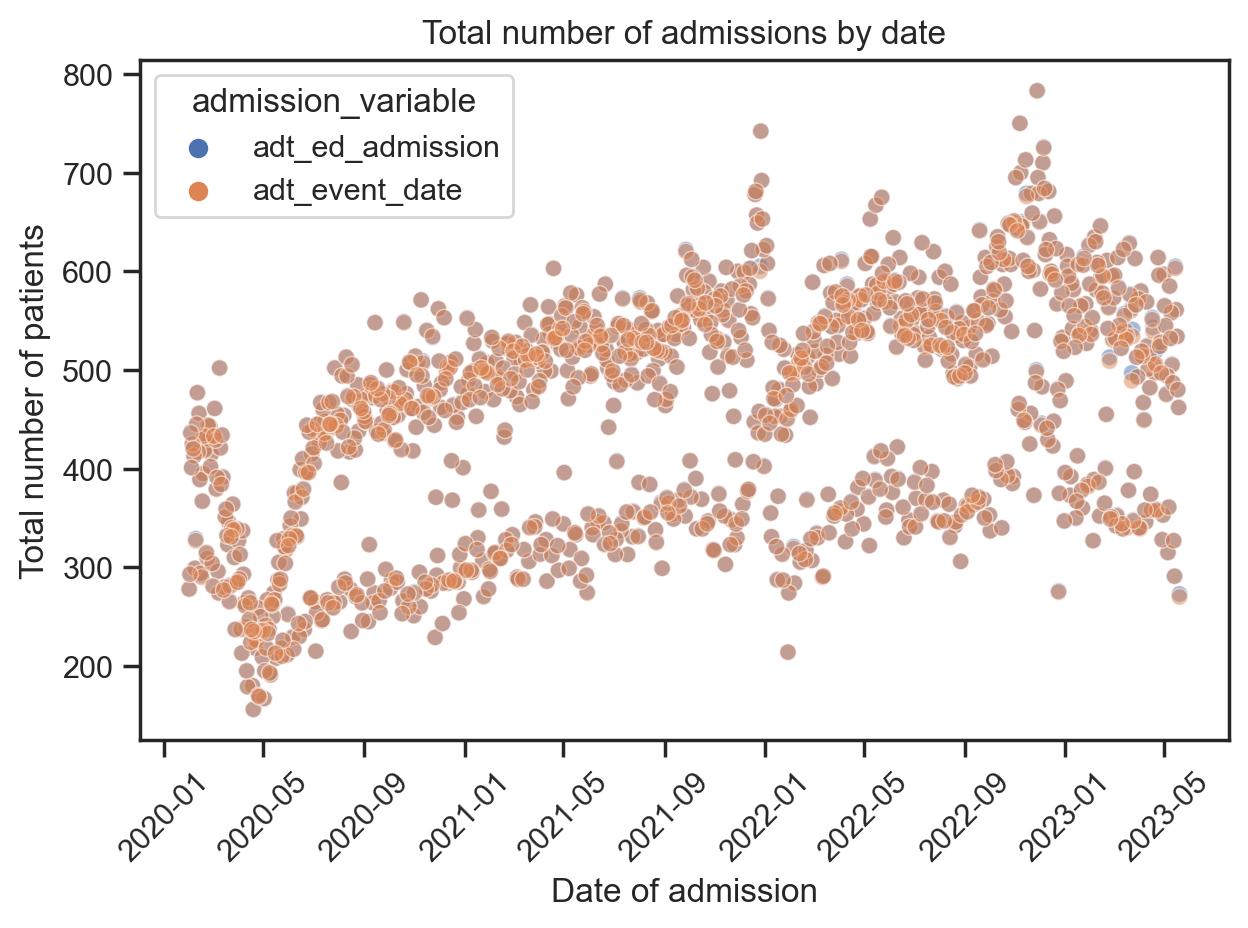

In [67]:
#| label: fig-admissions
#| fig-cap: "Total number of admissions reported in the database by date"

# Obtain unique date-mrn combinations
admissions_mrn_event = (data_abm
                        .filter(pl.col("adt_event_type") == "Admission")
                        .unique(subset=["mrn", "adt_event_date"], keep="first", maintain_order=True))

admissions_ed_mrn = (data_abm
                     .with_columns(pl.col("adt_ed_admission").cast(pl.Date).alias("admission_date"))
                     .unique(subset=["mrn", "admission_date"], keep="first", maintain_order=True))

# Count the combinations
count_admission_ed = (admissions_ed_mrn
                      .groupby("admission_date", maintain_order=True)
                      .agg(pl.count())
                      .rename({"admission_date": "date"})
                      .with_columns(pl.lit("adt_ed_admission").alias("admission_variable")))

count_admission_event = (admissions_mrn_event
                         .groupby("adt_event_date", maintain_order=True)
                         .agg(pl.count())
                         .rename({"adt_event_date": "date"})
                         .with_columns(pl.lit("adt_event_date").alias("admission_variable")))

complete_count = count_admission_ed.vstack(count_admission_event)

plt.figure()
ax = sns.scatterplot(data=complete_count.to_pandas(), x="date", y="count", hue = "admission_variable", alpha = 0.5)
ax.set_ylabel("Total number of patients")
ax.set_xlabel("Date of admission")
plt.title('Total number of admissions by date')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#Plot the difference TODO

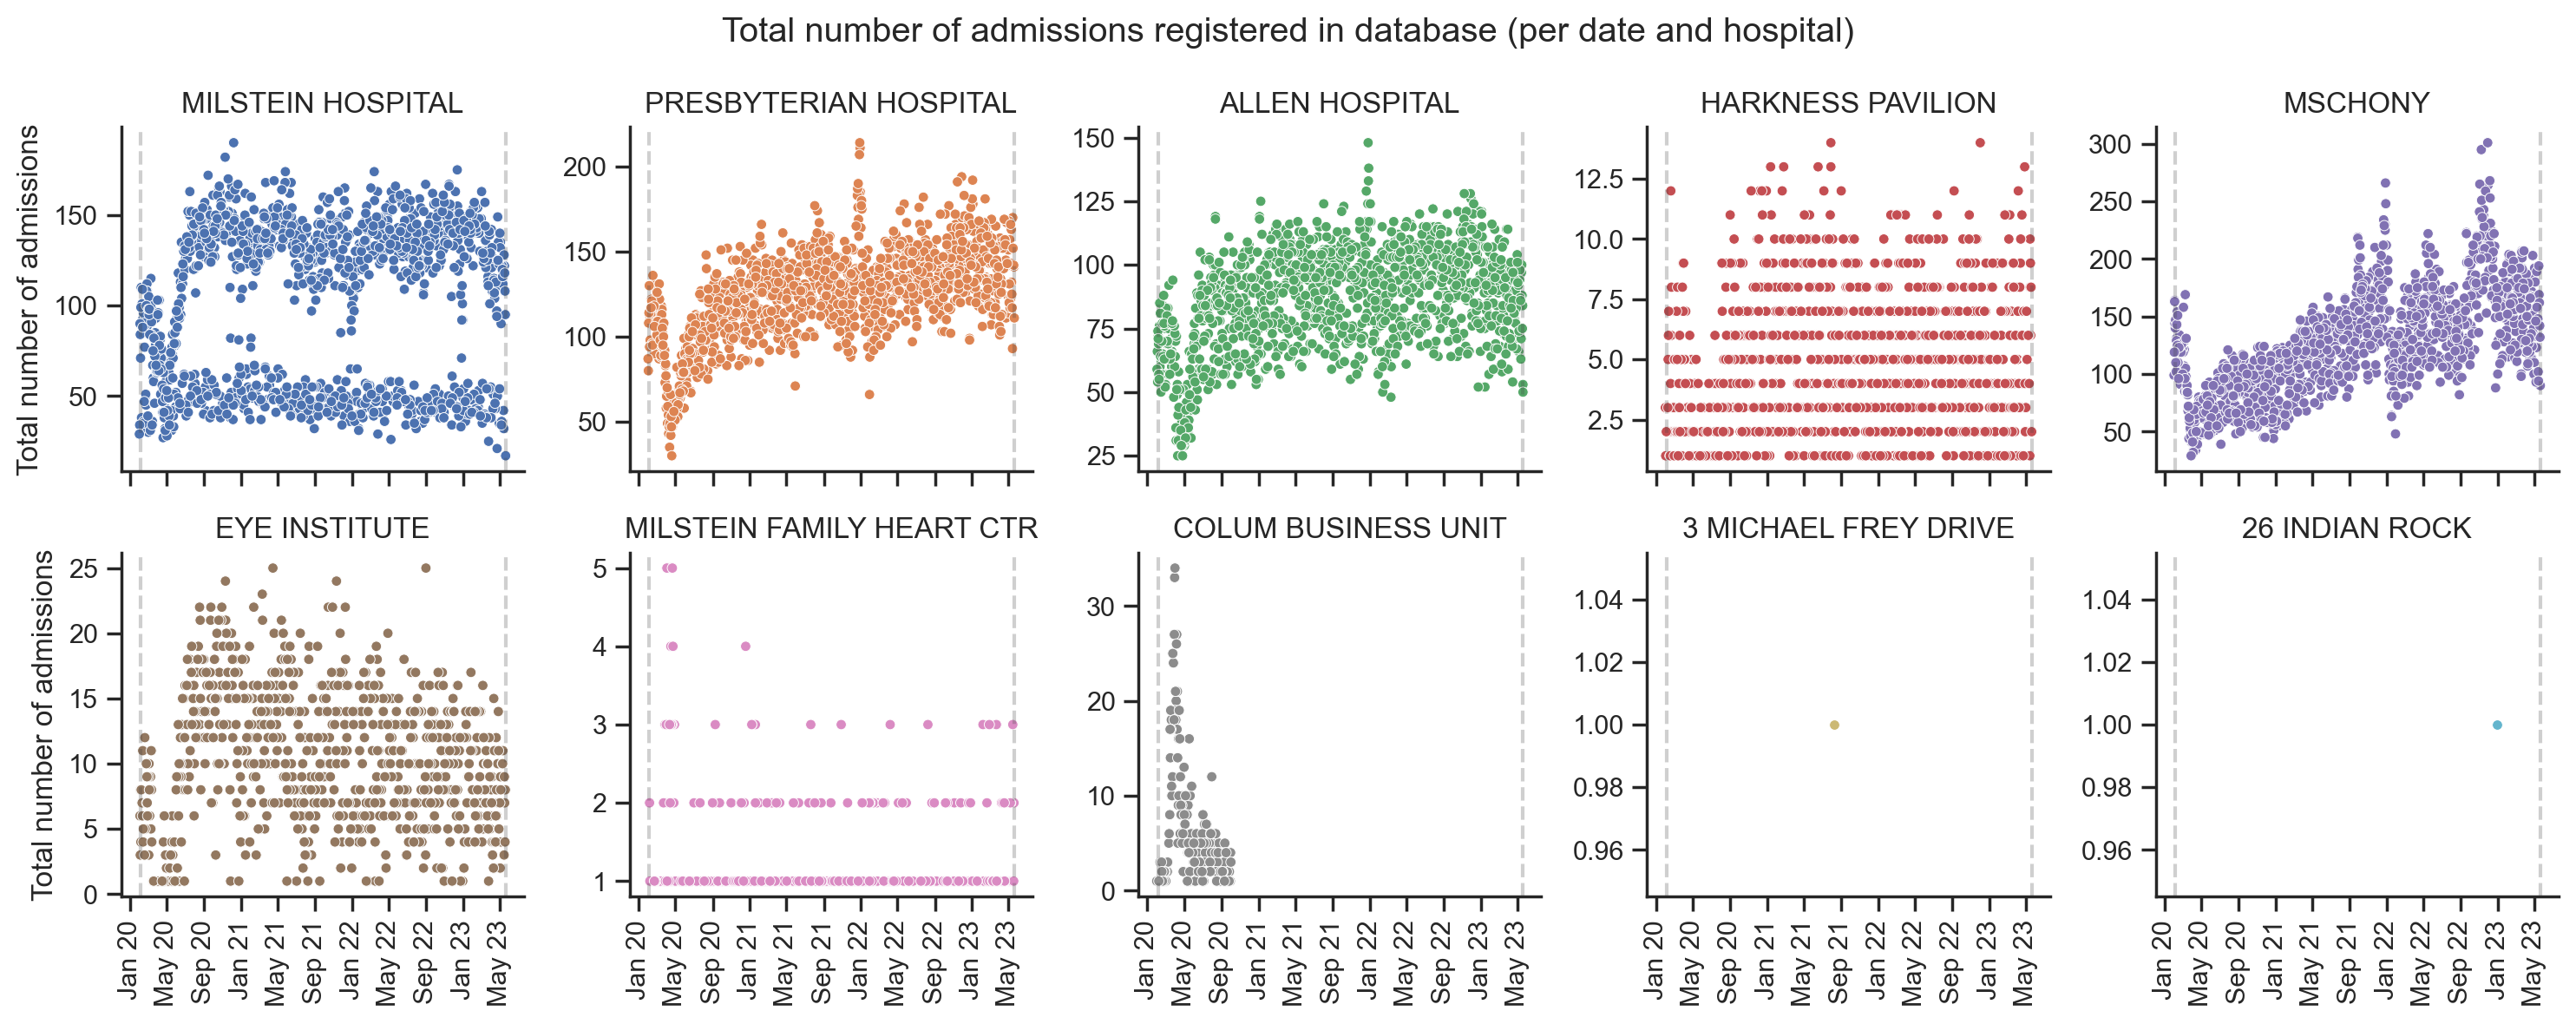

In [68]:
#| label: fig-admissions-hospital
#| fig-cap: "Total number of admissions reported in the database by institution `site_check`"

# Obtain unique date-mrn combinations
admissions_mrn_hosp = (data_abm
                        .filter(pl.col("adt_event_type") == "Admission")
                        .unique(subset=["mrn", "adt_event_date","site_check"], keep="first", maintain_order=True))

admissions_ed_mrn_hosp = (data_abm
                     .with_columns(pl.col("adt_ed_admission").cast(pl.Date).alias("admission_date"))
                     .unique(subset=["mrn", "admission_date","site_check"], keep="first", maintain_order=True))

# Count the combinations
count_admission_ed_hosp = (admissions_ed_mrn
                      .groupby(["admission_date","site_check"], maintain_order=True)
                      .agg(pl.count())
                      .rename({"admission_date": "date"})
                      .with_columns(pl.lit("adt_ed_admission").alias("admission_variable")))

count_admission_event_hosp = (admissions_mrn_event
                         .groupby(["adt_event_date","site_check"], maintain_order=True)
                         .agg(pl.count())
                         .rename({"adt_event_date": "date"})
                         .with_columns(pl.lit("adt_event_date").alias("admission_variable")))

complete_count_hosp = count_admission_ed_hosp.vstack(count_admission_event_hosp)

# Plot by hospital
g = sns.FacetGrid(complete_count_hosp.to_pandas(), col="site_check", hue="site_check", col_wrap=5, sharey=False)
g.map(sns.scatterplot, "date", "count", size = 10)
g.set_axis_labels("", "Total number of admissions")
g.set_titles(col_template="{col_name}", row_template="{row_name}")
g.fig.subplots_adjust(top=.9)
g.fig.suptitle('Total number of admissions registered in database (per date and hospital)')

for ax in g.axes.flat:
    ax.axvline(x = init_date, ymin = 0, linestyle = '--', alpha = 0.25, color = "#404040") 
    ax.axvline(x = end_date, ymin = 0, linestyle = '--', alpha = 0.25, color = "#404040") 
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    ax.xaxis.set_major_locator(FixedLocator(ax.get_xticks()))
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %y"))

plt.tight_layout()
plt.show()

# Admissions and discharge analysis

## Admission and discharge relationship from `adt_event_time` 

Check the discharge and admission rate of individuals so that all individuals are admitted before being discharged. For these variables we are using `adt_event_time` and `adt_event_type`. 

In [13]:
# Add previous admission date for all individuals
data_abm = data_abm.join_asof(
    data_abm
     .filter((pl.col('adt_event_type')=='Admission')) #| (pl.col('adt_event_type') == "Transfer In"))
     .select(["mrn","adt_event_time"])
     .with_columns(pl.col("adt_event_time").cast(pl.Date).alias("latest_admission"))
     .unique()
     .sort("mrn","adt_event_time"), on='adt_event_time', by='mrn', strategy = "backward")

# Add next discharge date for all individuals
data_abm = data_abm.join_asof(
    data_abm
     .filter((pl.col('adt_event_type')=='Discharge')) #| (pl.col('adt_event_type') == "Transfer Out"))
     .select(["mrn","adt_event_time"])
     .with_columns(pl.col("adt_event_time").cast(pl.Date).alias("latest_discharge"))
     .unique()
     .sort("mrn","adt_event_time"), on='adt_event_time', by='mrn', strategy = "forward")

# Add next event as a new column
data_abm = data_abm.with_columns([
    pl.col("adt_event_type").shift(1).over("mrn").alias("previous_adt_event_type"),
    pl.col("adt_event_time").shift(1).over("mrn").alias("previous_adt_event_time")])

# Select event types related to admission  / discharge
# and create the next event type column for these for each MRN
df_event_types  = (data_abm.select(["mrn", "adt_event_time","site_check","adt_event_type","adt_ed_admission","adt_discharge"])
                           .filter((pl.col("adt_event_type") == "Discharge") | 
                                   (pl.col("adt_event_type") == "Admission"))
                            .sort(["mrn","adt_event_time"])
                            .with_columns([
                                pl.col("adt_event_type").shift(1).over("mrn").alias("previous_adt_event_type"),
                                pl.col("adt_event_time").shift(1).over("mrn").alias("previous_adt_event_time")
                            ]))

## Individuals that were discharged without admission event

We check for individuals that were were discharged without being admitted first. Here we are counting individuals without an `adt_event_type` that is an Admission (even though all have `adt_ed_admission`)

In [14]:
# Filter those observations that were transfered out or discharged 
# but the previous transfer event was not an admission / transfer
discharged_without_transfer = df_event_types.filter(
    (pl.col("adt_event_type") == "Discharge") & #| (pl.col("adt_event_type") == "Transfer Out")) & 
    (pl.col("previous_adt_event_type") != "Admission")) #& (pl.col("previous_adt_event_type") != "Transfer In"))

if (discharged_without_transfer.shape[0] > 0):
    
    print(f'❌ A total of {discharged_without_transfer.shape[0]} observations were' + 
      ' discharged without being admittted before')

    # From these individuals count the number of transfers that the next one was also a transfer / discharge
    duplicated_discharge_transfer = discharged_without_transfer.filter(
        (pl.col("adt_event_type") == "Discharge") & #| (pl.col("adt_event_type") == "Transfer Out")) &
        (pl.col("previous_adt_event_type") == "Discharge") & #| (pl.col("previous_adt_event_type") == "Transfer Out")) &
        (pl.col("adt_event_time") - pl.col("previous_adt_event_time") <= dt.timedelta(days=1)))
    
    print(f'\tof these, {duplicated_discharge_transfer.shape[0]} observations seem to be' +
          ' duplicate discharge registries\n\tas they occurr with <= 1 day difference from' +
          'each other.')

    unique_ids = discharged_without_transfer.filter(
     ~((pl.col("adt_event_type") == "Discharge") & #| (pl.col("adt_event_type") == "Transfer Out")) &
        (pl.col("previous_adt_event_type") == "Discharge") & #| (pl.col("previous_adt_event_type") == "Transfer Out")) &
        (pl.col("adt_event_time") - pl.col("previous_adt_event_time") <= dt.timedelta(days=1))))

    unique_ids_vals = unique_ids.select("mrn").unique().to_pandas()["mrn"]
    print(f'>>There are {discharged_without_transfer.shape[0] - duplicated_discharge_transfer.shape[0]}' +
          f' observations corresponding to {unique_ids_vals.shape[0]} individuals\n>>that need to be checked.')
     
else: 
    unique_ids_vals = []
    print(f"✅ {discharged_without_transfer.shape[0]} all discharge observations" +  
        " have a corresponding admission")


❌ A total of 2864 observations were discharged without being admittted before
	of these, 2658 observations seem to be duplicate discharge registries
	as they occurr with <= 1 day difference fromeach other.
>>There are 206 observations corresponding to 203 individuals
>>that need to be checked.


An example of what this looks like can be seen with the following individual. Notice the suspicious admission exactly at midnight. 

In [15]:
if len(unique_ids_vals) > 0:
    with pd.option_context('display.max_rows', 1000, 'display.max_columns', 10,'display.max_colwidth', None):
        display(data_abm
                .filter(pl.col("mrn").is_in(unique_ids_vals[2:3]))
                .sort(["mrn","adt_event_time"])
                .select(["mrn","adt_event_time","adt_event_type","previous_adt_event_type",
                         "previous_adt_event_time","adt_ed_admission","adt_discharge"]))
else:
    print(f"No example everything is perfect")

mrn,adt_event_time,adt_event_type,previous_adt_event_type,previous_adt_event_time,adt_ed_admission,adt_discharge
i64,datetime[μs],str,str,datetime[μs],datetime[μs],datetime[μs]
1001844267,2021-10-05 22:26:00,"""Admission""",null,null,2021-10-05 22:26:00,2021-10-10 19:03:00
1001844267,2021-10-05 23:59:00,"""Census""","""Admission""",2021-10-05 22:26:00,2021-10-05 22:26:00,2021-10-10 19:03:00
1001844267,2021-10-06 05:08:00,"""Patient Update…","""Census""",2021-10-05 23:59:00,2021-10-05 22:26:00,2021-10-10 19:03:00
1001844267,2021-10-06 12:00:00,"""Patient Update…","""Patient Update…",2021-10-06 05:08:00,2021-10-05 22:26:00,2021-10-10 19:03:00
1001844267,2021-10-06 15:28:00,"""Transfer In""","""Patient Update…",2021-10-06 12:00:00,2021-10-05 22:26:00,2021-10-10 19:03:00
1001844267,2021-10-06 15:28:00,"""Transfer Out""","""Transfer In""",2021-10-06 15:28:00,2021-10-05 22:26:00,2021-10-10 19:03:00
1001844267,2021-10-06 16:09:00,"""Patient Update…","""Transfer Out""",2021-10-06 15:28:00,2021-10-05 22:26:00,2021-10-10 19:03:00
1001844267,2021-10-06 23:59:00,"""Census""","""Patient Update…",2021-10-06 16:09:00,2021-10-05 22:26:00,2021-10-10 19:03:00
1001844267,2021-10-07 17:26:00,"""Transfer In""","""Census""",2021-10-06 23:59:00,2021-10-05 22:26:00,2021-10-10 19:03:00


After seeing this. I checked the `adt_ed_admission` to see if there were people that didn't have an admission:

### Check for individuals that were never admitted

Here we check the number of individuals with a null `adt_ed_admission`

In [16]:
individuals_never_admitted = (data_abm
                              .filter(pl.Expr.is_null(pl.col("adt_ed_admission")))
                              .select("mrn")
                              .unique())

if individuals_never_admitted.shape[0] > 0:
    print(f"❌ {individuals_never_admitted.shape[0]} individuals don't have an admission date")
else:
    print(f"✅ All individuals have at least one admission date (`adt_ed_admission`)")
    

✅ All individuals have at least one admission date (`adt_ed_admission`)


::: {.callout-tip title="Actions"}
### Suggested course of action
+ Account for patients presence using `adt_ed_admission` even though it is suspicious sometimes. 

:::

## Individuals that were re-admitted without being discharged

We check for individuals that were transfered-in/admitted without having been previously discharged/transfered-out. This metric is for only _repeated_ individuals (not for individuals that appear for the first time in the database). This is based upon `adt_event_type`. 

In [17]:
# Filter those observations that were transfered out or discharged 
# but the previous transfer event was not an admission / transfer
# Filter those observations that were transfered out or discharged 
# but the previous transfer event was not an admission / transfer
admitted_without_discharge = df_event_types.filter(
    (pl.col("adt_event_type") == "Admission") & 
    (pl.Expr.is_not_null(pl.col("previous_adt_event_type"))) & 
    (pl.col("previous_adt_event_type") != "Discharge"))

if (admitted_without_discharge.shape[0] > 0):
    
    print(f'❌ A total of {admitted_without_discharge.shape[0]} observations were' + 
      ' re-admitted without being discharged before')

    # From these individuals count the number of transfers that the next one was also a transfer / discharge
    duplicated_admitted_discharge = admitted_without_discharge.filter(
        (pl.col("adt_event_type") == "Admission") & #| (pl.col("adt_event_type") == "Transfer Out")) &
        (pl.col("previous_adt_event_type") == "Admission") & #| (pl.col("previous_adt_event_type") == "Transfer Out")) &
        (pl.col("adt_event_time") - pl.col("previous_adt_event_time") <= dt.timedelta(days=1)))
    
    print(f'\tof these, {duplicated_admitted_discharge.shape[0]} observations seem to be' +
          ' duplicate admission registries\n\tas they occurr with <= 1 day difference from' +
          'each other.')

    unique_ids = admitted_without_discharge.filter(
     ~((pl.col("adt_event_type") == "Admission") & #| (pl.col("adt_event_type") == "Transfer Out")) &
        (pl.col("previous_adt_event_type") == "Admission") & #| (pl.col("previous_adt_event_type") == "Transfer Out")) &
        (pl.col("adt_event_time") - pl.col("previous_adt_event_time") <= dt.timedelta(days=1))))

    unique_ids_vals = unique_ids.select("mrn").unique().to_pandas()["mrn"]
    print(f'>>There are {admitted_without_discharge.shape[0] - duplicated_admitted_discharge.shape[0]}' +
          f' observations corresponding to {unique_ids_vals.shape[0]} individuals\n>>that need to be checked.')
     
else: 
    unique_ids_vals = []
    print(f"✅ {admitted_without_discharge.shape[0]} all re.admission observations" +  
        " have a corresponding discharge")


❌ A total of 4269 observations were re-admitted without being discharged before
	of these, 3829 observations seem to be duplicate admission registries
	as they occurr with <= 1 day difference fromeach other.
>>There are 440 observations corresponding to 436 individuals
>>that need to be checked.


An example of what's going on can be seen in the following patient:

In [18]:
if len(unique_ids_vals) > 0:
    with pd.option_context('display.max_rows', 1000, 'display.max_columns', 10,'display.max_colwidth', None):
        display(data_abm
                .filter(pl.col("mrn").is_in(unique_ids_vals[6:7]))
                .select(["mrn","adt_event_time","adt_event_type","previous_adt_event_type",
                         "previous_adt_event_time","adt_ed_admission","adt_discharge"])
                .sort(["mrn","adt_event_time"])
                .head(n=50))
else:
    print(f"No example everything is perfect")

mrn,adt_event_time,adt_event_type,previous_adt_event_type,previous_adt_event_time,adt_ed_admission,adt_discharge
i64,datetime[μs],str,str,datetime[μs],datetime[μs],datetime[μs]
1000598267,2021-03-22 10:19:00,"""Admission""",null,null,2021-03-22 10:19:00,2021-03-22 16:10:00
1000598267,2021-03-22 16:10:00,"""Discharge""","""Admission""",2021-03-22 10:19:00,2021-03-22 10:19:00,2021-03-22 16:10:00
1000598267,2023-01-30 13:00:00,"""Admission""","""Discharge""",2021-03-22 16:10:00,2023-01-30 13:00:00,2023-02-10 10:00:00
1000598267,2023-01-30 23:59:00,"""Census""","""Admission""",2023-01-30 13:00:00,2023-01-30 13:00:00,2023-02-10 10:00:00
1000598267,2023-01-31 23:59:00,"""Census""","""Census""",2023-01-30 23:59:00,2023-01-30 13:00:00,2023-02-10 10:00:00
1000598267,2023-02-01 23:59:00,"""Census""","""Census""",2023-01-31 23:59:00,2023-01-30 13:00:00,2023-02-10 10:00:00
1000598267,2023-02-02 23:59:00,"""Census""","""Census""",2023-02-01 23:59:00,2023-01-30 13:00:00,2023-02-10 10:00:00
1000598267,2023-02-03 23:59:00,"""Census""","""Census""",2023-02-02 23:59:00,2023-01-30 13:00:00,2023-02-10 10:00:00
1000598267,2023-02-04 23:59:00,"""Census""","""Census""",2023-02-03 23:59:00,2023-01-30 13:00:00,2023-02-10 10:00:00


### Check for individuals that were never discharged

In [19]:
individuals_never_discharged = data_abm.filter(pl.Expr.is_null(pl.col("adt_discharge")))
individuals_dont_discharged_latest = individuals_never_discharged.filter(pl.Expr.is_null(pl.col("latest_discharge")))

if individuals_never_discharged.shape[0] > 0:

    size_ind_2 = individuals_dont_discharged_latest.select(["mrn"]).unique().shape[0]
    print(f"❌ {size_ind_2} individuals don't have a discharge date")
    
    #Check those that last up to 2020-05-20
    ind_2023 = individuals_dont_discharged_latest.groupby('mrn').agg([pl.col('adt_event_time').max()])
    ind_2023 = ind_2023.filter(pl.col("adt_event_time") < dt.datetime.strptime("2023-05-19", '%Y-%m-%d').date())
    
    print(f"of these, {ind_2023.shape[0]} have their latest date before ymd: 2023-05-19")
    
    with pd.option_context('display.max_rows', 1000, 'display.max_columns', 10,'display.max_colwidth', None):
            display(individuals_never_discharged
                        .filter(pl.col("mrn").is_in(ind_2023.to_pandas()["mrn"]))
                        .sort(["mrn","adt_event_time"])
                        .select(["mrn","adt_event_time","adt_event_type","latest_admission","latest_discharge",
                                 "adt_discharge","adt_ed_admission"])
                        .head(n=52))
else:
    print(f"✅ All individuals have at least one discharge date in `adt_discharge`")
        

❌ 1217 individuals don't have a discharge date
of these, 189 have their latest date before ymd: 2023-05-19


mrn,adt_event_time,adt_event_type,latest_admission,latest_discharge,adt_discharge,adt_ed_admission
i64,datetime[μs],str,date,date,datetime[μs],datetime[μs]
1000087381,2022-07-18 05:09:00,"""Admission""",2022-07-18,null,null,2022-07-18 05:09:00
1000087381,2022-07-18 15:02:00,"""Patient Update…",2022-07-18,null,null,2022-07-18 05:09:00
1000087381,2022-07-18 23:59:00,"""Census""",2022-07-18,null,null,2022-07-18 05:09:00
1000232180,2023-03-15 14:43:00,"""Admission""",2023-03-15,null,null,2023-03-15 14:43:00
1000232180,2023-03-15 15:03:00,"""Transfer Out""",2023-03-15,null,null,2023-03-15 14:43:00
1000232180,2023-03-15 15:03:00,"""Transfer In""",2023-03-15,null,null,2023-03-15 14:43:00
1000232180,2023-03-15 23:59:00,"""Census""",2023-03-15,null,null,2023-03-15 14:43:00
1000268331,2023-02-01 13:16:00,"""Admission""",2023-02-01,null,null,2023-02-01 13:16:00
1000268331,2023-02-01 23:59:00,"""Census""",2023-02-01,null,null,2023-02-01 13:16:00


::: {.callout-tip title="Actions"}
### Suggested course of action
+ Discharge individuals that don't have a discharge date the moment their latest date happens (except for individuals whose latest date is 2023-05-19 or more. 
+ Use the discharge registered at `adt_discharge` if no `adt_event_type` discharge is found and viceversa. 

:::

## Other checks

### Individuals who only had one observation

We check for individuals for which there was only one observation. In theory you should have at least two (admission + discharge)

In [20]:
only_once_observed = (data_abm
                      .groupby("mrn")
                      .agg(pl.count())
                      .filter(pl.col("count") == 1)
                      .to_pandas()["mrn"])

data_abm.filter(pl.col("mrn").is_in(only_once_observed))

mrn,adt_care_level,adt_status,adt_location,adt_site,encounter_id,adt_event_type,adt_event_time,adt_ed_admission,adt_inpatient,adt_discharge,adt_discharge_disp,room_num,site_check,frequency,adt_site_name_std,adt_site_number_std,adt_discharge_disp_code,deceased_check,adt_event_date,room_8pm,hospital_block,hospital_block_8pm,event_type_order,latest_admission,latest_discharge,previous_adt_event_type,previous_adt_event_time
i64,str,str,str,str,i64,str,datetime[μs],datetime[μs],datetime[μs],datetime[μs],str,str,str,i64,str,i64,i64,datetime[μs],date,str,str,str,i32,date,date,str,datetime[μs]
1000508831,"""Acute (Floor)""","""Acute (Floor)""","""ALN OPERATING …","""ALLEN HOSPITAL…",206001043,"""Admission""",2022-12-07 08:15:00,2022-12-07 08:15:00,null,2022-12-07 23:55:00,"""Home or Self C…","""ALN OPERATING …","""ALLEN HOSPITAL…",123627,"""Allen Hospital…",2,15,null,2022-12-07,"""ALN OPERATING …","""ALN OPERATING …","""ALN OPERATING …",-1,2022-12-07,null,null,null
1007871591,"""Emergency""",null,"""CUIMC ED TELEM…","""COLUM BUSINESS…",120178131,"""Discharge""",2020-05-08 11:22:00,2020-05-08 10:51:00,null,2020-05-08 11:22:00,"""Home or Self C…","""CUIMC ED TELEM…","""COLUM BUSINESS…",3634,"""Columbia""",1,15,null,2020-05-08,"""Not in Hospita…","""CUIMC ED TELEM…","""Not in Hospita…",1,null,2020-05-08,null,null
1008370056,null,null,"""MSCH N2 COL PR…","""MSCHONY""",108679945,"""Discharge""",2020-02-03 09:59:00,2020-02-03 00:00:00,null,2020-02-03 09:59:00,"""Home or Self C…",null,"""MSCHONY""",114993,"""CHONY""",3,15,null,2020-02-03,"""Not in Hospita…",null,"""Not in Hospita…",1,null,2020-02-03,null,null
1008775220,"""Emergency""",null,"""PBY ADULT EMER…","""PRESBYTERIAN H…",185007443,"""Admission""",2022-03-11 23:07:00,2022-03-11 23:07:00,null,null,null,"""PBY ADULT EMER…","""PRESBYTERIAN H…",87884,"""Columbia""",1,null,null,2022-03-11,"""Not in Hospita…","""PBY ADULT EMER…","""Not in Hospita…",-1,2022-03-11,null,null,null
1009447188,"""Emergency""",null,"""PBY ADULT EMER…","""PRESBYTERIAN H…",198998488,"""Discharge""",2022-08-03 08:10:00,2022-08-03 00:00:00,null,2022-08-03 08:10:00,"""Home or Self C…","""PBY ADULT EMER…","""PRESBYTERIAN H…",87884,"""Columbia""",1,15,null,2022-08-03,"""Not in Hospita…","""PBY ADULT EMER…","""Not in Hospita…",1,null,2022-08-03,null,null
1010197496,"""Emergency""",null,"""ALN EMERGENCY""","""ALLEN HOSPITAL…",212711968,"""Discharge""",2022-12-23 05:21:00,2022-12-23 00:00:00,null,2022-12-23 05:21:00,"""Home or Self C…","""ALN EMERGENCY …","""ALLEN HOSPITAL…",123627,"""Allen Hospital…",2,15,null,2022-12-23,"""Not in Hospita…","""ALN EMERGENCY …","""Not in Hospita…",1,null,2022-12-23,null,null
1010426542,null,null,"""MSCH N2 COL PR…","""MSCHONY""",117436087,"""Discharge""",2020-04-15 12:44:00,2020-04-15 00:00:00,null,2020-04-15 12:44:00,"""Home or Self C…",null,"""MSCHONY""",114993,"""CHONY""",3,15,null,2020-04-15,"""Not in Hospita…",null,"""Not in Hospita…",1,null,2020-04-15,null,null
1101126052,"""Emergency""",null,"""CUIMC ED TELEM…","""COLUM BUSINESS…",121016039,"""Discharge""",2020-05-30 11:07:00,2020-05-30 10:47:00,null,2020-05-30 11:07:00,"""Home or Self C…","""CUIMC ED TELEM…","""COLUM BUSINESS…",3634,"""Columbia""",1,15,null,2020-05-30,"""Not in Hospita…","""CUIMC ED TELEM…","""Not in Hospita…",1,null,2020-05-30,null,null
1102943126,"""Emergency""",null,"""MSCH EMERGENCY…","""MSCHONY""",178355289,"""Discharge""",2021-12-26 01:19:00,2021-12-26 00:00:00,null,2021-12-26 01:19:00,"""Home or Self C…","""MSCH EMERGENCY…","""MSCHONY""",114993,"""CHONY""",3,15,null,2021-12-26,"""Not in Hospita…","""MSCH EMERGENCY…","""Not in Hospita…",1,null,2021-12-26,null,null


### Check for continuity of dates within individuals

Here we check that individuals don't have missing days in the hospital

In [21]:
# Get one value per day of individual
individuals_all_days_hospital = (
    data_abm
     .groupby(["mrn","adt_event_date"])
     .agg(pl.all().sort_by('event_type_order').last())
     .sort(["mrn","adt_event_time"])
)

# Input first day so that time difference is 0 for individual already in hospital
individuals_all_days_hospital = (individuals_all_days_hospital
    .with_columns(
        pl.when(pl.Expr.is_null(pl.col("previous_adt_event_time")))
        .then(pl.col("adt_event_time"))
        .otherwise(pl.col("previous_adt_event_time"))
        .alias("previous_adt_event_time_0_inputed"))
)

# Calculate the time delta between one observation and the previous one for each individual
individuals_all_days_hospital = (individuals_all_days_hospital
    .with_columns(
        (pl.col("adt_discharge").cast(pl.Date) - pl.col("adt_ed_admission").cast(pl.Date)).dt.days().alias("day_difference")
    ))

# Count the number of unique observations across mrn/admission
individuals_all_days_hospital = (individuals_all_days_hospital
    .with_columns(pl.col("adt_ed_admission").cast(pl.Date).alias("admission_date_ed"))
    .sort("admission_date_ed")
    .with_columns(pl.col("admission_date_ed").cumcount().over(["mrn","admission_date_ed"]).alias("obs_count")))

#Check values make sense
mrns_values = individuals_all_days_hospital.filter(pl.col("obs_count") > pl.col("day_difference")).to_pandas()["mrn"]

if len(mrns_values) < 1:
     print(f"✅ All individuals have at least one registry per day between admission_date and discharge_date")
else:
     print(f"❌ {len(mrns_values)} individuals disappear at least one day between admission_date and discharge_date")


✅ All individuals have at least one registry per day between admission_date and discharge_date


### Check for date continuity of individuals when removing null rooms

In [22]:
# Get one value per day of individual
individuals_all_days_hospital = (
    data_abm
     .filter(pl.Expr.is_not_null(pl.col("room_num")))
     .groupby(["mrn","adt_event_date"])
     .agg(pl.all().sort_by('event_type_order').last())
     .sort(["mrn","adt_event_time"])
)

# Input first day so that time difference is 0 for individual already in hospital
individuals_all_days_hospital = (individuals_all_days_hospital
    .with_columns(
        pl.when(pl.Expr.is_null(pl.col("previous_adt_event_time")))
        .then(pl.col("adt_event_time"))
        .otherwise(pl.col("previous_adt_event_time"))
        .alias("previous_adt_event_time_0_inputed"))
)

# Calculate the time delta between one observation and the previous one for each individual
individuals_all_days_hospital = (individuals_all_days_hospital
    .with_columns(
        (pl.col("adt_discharge").cast(pl.Date) - pl.col("adt_ed_admission").cast(pl.Date)).dt.days().alias("day_difference")
    ))

# Count the number of unique observations across mrn/admission
individuals_all_days_hospital = (individuals_all_days_hospital
    .with_columns(pl.col("adt_ed_admission").cast(pl.Date).alias("admission_date_ed"))
    .sort("admission_date_ed")
    .with_columns(pl.col("admission_date_ed").cumcount().over(["mrn","admission_date_ed"]).alias("obs_count")))

#Check values make sense
mrns_values = individuals_all_days_hospital.filter(pl.col("obs_count") > pl.col("day_difference")).to_pandas()["mrn"]

if len(mrns_values) < 1:
     print(f"✅ All individuals have at least one room per day between admission_date and discharge_date")
else:
     print(f"❌ {len(mrns_values)} individuals have missing rooms at least one day between admission_date and discharge_date")


✅ All individuals have at least one room per day between admission_date and discharge_date


### Check for non-missing location

In [23]:
# Get one value per day of individual
individuals_all_days_hospital = (
    data_abm
     .filter(pl.Expr.is_not_null(pl.col("adt_location")))
     .groupby(["mrn","adt_event_date"])
     .agg(pl.all().sort_by('event_type_order').last())
     .sort(["mrn","adt_event_time"])
)

# Input first day so that time difference is 0 for individual already in hospital
individuals_all_days_hospital = (individuals_all_days_hospital
    .with_columns(
        pl.when(pl.Expr.is_null(pl.col("previous_adt_event_time")))
        .then(pl.col("adt_event_time"))
        .otherwise(pl.col("previous_adt_event_time"))
        .alias("previous_adt_event_time_0_inputed"))
)

# Calculate the time delta between one observation and the previous one for each individual
individuals_all_days_hospital = (individuals_all_days_hospital
    .with_columns(
        (pl.col("adt_discharge").cast(pl.Date) - pl.col("adt_ed_admission").cast(pl.Date)).dt.days().alias("day_difference")
    ))

# Count the number of unique observations across mrn/admission
individuals_all_days_hospital = (individuals_all_days_hospital
    .with_columns(pl.col("adt_ed_admission").cast(pl.Date).alias("admission_date_ed"))
    .sort("admission_date_ed")
    .with_columns(pl.col("admission_date_ed").cumcount().over(["mrn","admission_date_ed"]).alias("obs_count")))

#Check values make sense
mrns_values = individuals_all_days_hospital.filter(pl.col("obs_count") > pl.col("day_difference")).to_pandas()["mrn"]

if len(mrns_values) < 1:
     print(f"✅ All individuals have at least one location per day between admission_date and discharge_date")
else:
     print(f"❌ {len(mrns_values)} individuals have missing locations at least one day between admission_date and discharge_date")


✅ All individuals have at least one location per day between admission_date and discharge_date


# Hospital structure validation

Here we verify that rooms belong to the same ward and wards belong to the same hospital. This is important to ensure the validity of the model's structure. The expected structure is:
$$
\text{Room} \subseteq \text{Ward} \subseteq \text{Hospital}
$$
We are identifying `room_num` with `Room`, either `adt_location` or `hospital_block` as ward and `adt_site/site_check` for hospital. 

In [24]:
# Get first letters of room/location and block as hospital name
data_abm = (data_abm
                .with_columns([
                    pl.col("room_num")
                        .str.split_exact(" ", 0)
                        .struct
                        .rename_fields(["room_recovered_name"])
                        .alias("fields_room"),
                    pl.col("adt_location")
                        .str.split_exact(" ", 0)
                        .struct
                        .rename_fields(["location_recovered_name"])
                        .alias("fields_location"),
                    pl.col("hospital_block")
                        .str.split_exact(" ", 0)
                        .struct
                        .rename_fields(["block_recovered_name"])
                        .alias("fields_block")])
                .unnest(["fields_room","fields_location","fields_block"]))


# Function that checks that all values in column A belong to unique values of column B. 
# The ideal would be checking A = rooms and B = hospitals so that all rooms belong to hospitals. 
def check_A_inside_B(df, column_A="room_num", column_B="site_check", valuename_A="room", valuename_B="hospital"):
    
    #Get subset of A and B values
    df_A_B = (df.select([column_A, column_B])
                .filter(pl.Expr.is_not_null(pl.col(column_A)))
                .unique())

    #Get the list of all A values
    df_A = (df.select([column_A])
              .unique())

    #Check if A values are repeated
    repeated_A = (df_A_B.groupby(column_A)
                        .agg(pl.count())
                        .sort("count", descending=True)
                        .filter(pl.col("count") > 1))

    if (repeated_A.shape[0] > 0):
        
        print(f"❌ {repeated_A.shape[0]} {valuename_A}s (`{column_A}`) appear in more than one {valuename_B} (`{column_B}`)")

        #Verify the values of the repeated rooms
        repeated_A_values = (repeated_A
                                 .select(column_A)
                                 .unique()
                                 .to_pandas()[column_A])
        
        A_B_repeated = df_A_B.filter(pl.col(column_A).is_in(repeated_A_values))

        print(f"---------These are some of the repeated {valuename_A}s (`{column_A}`):---------")
        with pd.option_context('display.max_rows', 1000, 'display.max_columns', 10,'display.max_colwidth', None):
            display(repeated_A_values.head(n=10))
            
        print(f"---------Here are some of the {valuename_A}s (`{column_A}`)  with multiple sites:---------")
        with pd.option_context('display.max_rows', 1000, 'display.max_columns', 10,'display.max_colwidth', None):
            display(A_B_repeated.sort(column_A).to_pandas().head(n=10))

    else:
        print(f"✅ All {valuename_A}s (`{column_A}`) appear only in one {valuename_B} (`{column_B}`)")

## Check for telemedicine

In [25]:
telemedicine = (data_abm
     .filter(pl.col("room_num").str.contains("TELEMED") | pl.col("adt_location").str.contains("TELEMED")))

if telemedicine.shape[0] < 1:
     print(f"✅ No individuals where found at telemedicine")
else:
     print(f"❌ {telemedicine.shape[0]} individuals have a telemedicine room or location")


❌ 3156 individuals have a telemedicine room or location


::: {.callout-tip title="Actions"}
### Suggested course of action
+ Drop individuals in telemedicine registry. 
:::

## Check that `site_check` and `adt_site` contain same values

The variables `site_check` and `adt_site` should be describing the same and thus should be identical

In [26]:
site_adt = data_abm.filter(pl.col("site_check") != pl.col("adt_site"))
if (site_adt.shape[0] > 0):
    print(f"❌ {site_adt.shape[0]} values from `site_check` and `adt_site` don't match")
else:
    print(f"✅ All values from `site_check` and `adt_site` coincide")

✅ All values from `site_check` and `adt_site` coincide


## All rooms are in the same hospital

We check that room names are unique per hospital.

In [27]:
check_A_inside_B(data_abm, "room_num", "adt_site")

❌ 1143 rooms (`room_num`) appear in more than one hospital (`adt_site`)
---------These are some of the repeated rooms (`room_num`):---------


0               MIL 5 CTICU 5231
1        MIL 7 GARDEN NORTH 7446
2       HRT CARDIO THORACIC 5640
3    PBY ADULT EMERGENCY PSYCH02
4        MIL 5 HUDSON NORTH 5158
5        MIL 7 HUDSON NORTH 7156
6        MIL 7 HUDSON NORTH 7154
7      PBY ADULT EMERGENCY C14-H
8              MIL 9 HUDSON 9249
9      PBY ADULT EMERGENCY RME15
Name: room_num, dtype: object

---------Here are some of the rooms (`room_num`)  with multiple sites:---------


,room_num,adt_site
0,ALN 1 NICU 1120,ALLEN HOSPITAL
1,ALN 1 NICU 1120,MSCHONY
2,ALN 1 NICU 1122,ALLEN HOSPITAL
3,ALN 1 NICU 1122,MSCHONY
4,ALN 1 RIVER WEST 1063,ALLEN HOSPITAL
5,ALN 1 RIVER WEST 1063,MILSTEIN HOSPITAL
6,ALN 1 RIVER WEST 1063,MSCHONY
7,ALN 1 RIVER WEST 1068,MSCHONY
8,ALN 1 RIVER WEST 1068,ALLEN HOSPITAL
9,ALN 1 RIVER WEST 1069,ALLEN HOSPITAL


## All locations are in same hospital

Check that all locations are unique per hospital so that no ward belongs to multiple hospitals

In [28]:
check_A_inside_B(data_abm, "adt_location", "adt_site", "location")

✅ All locations (`adt_location`) appear only in one hospital (`adt_site`)


Repeat analysis using the hospital names recovered from the room name at `room_num`

In [29]:
check_A_inside_B(data_abm, "adt_location", "room_recovered_name", "location")

❌ 84 locations (`adt_location`) appear in more than one hospital (`room_recovered_name`)
---------These are some of the repeated locations (`adt_location`):---------


0                   ALN 1 NICU
1    MIL 3 ASU PALLIATIVE CARE
2              MSCH 11 CENTRAL
3           MIL 7 GARDEN NORTH
4                 MIL 4 MICU A
5             HRT CARDIAC CARE
6             ALN 2 FIELD WEST
7            MIL 4 ORICU SURGE
8           MIL 6 GARDEN SOUTH
9       MSCH 6 CENTRAL NURSERY
Name: adt_location, dtype: object

---------Here are some of the locations (`adt_location`)  with multiple sites:---------


,adt_location,room_recovered_name
0,ALN 1 NICU,ALN
1,ALN 1 NICU,MSCH
2,ALN 1 RIVER WEST,MSCH
3,ALN 1 RIVER WEST,ALN
4,ALN 2 FIELD EAST,HRK
5,ALN 2 FIELD EAST,HRT
6,ALN 2 FIELD EAST,None
7,ALN 2 FIELD EAST,MIL
8,ALN 2 FIELD EAST,ALN
9,ALN 2 FIELD EAST,PBY


## All blocks are in same hospital

Check that all blocks are unique per hospital so that no ward belongs to multiple hospitals

In [30]:
check_A_inside_B(data_abm, "hospital_block", "adt_site", "block", "hospital")

❌ 1031 blocks (`hospital_block`) appear in more than one hospital (`adt_site`)
---------These are some of the repeated blocks (`hospital_block`):---------


0        MSCH 10 CENTRAL 1005
1     MIL 6 HUDSON NORTH 6140
2    HRT RIVERVIEW TERRACE 04
3       ALN 2 FIELD EAST 2177
4          MIL 8 GARDEN SOUTH
5     MIL 7 HUDSON SOUTH 7221
6           MSCH EMERGENCY 10
7     MIL 6 GARDEN NORTH 6456
8        MSCH 10 CENTRAL 1010
9          MSCH EMERGENCY OTF
Name: hospital_block, dtype: object

---------Here are some of the blocks (`hospital_block`)  with multiple sites:---------


,hospital_block,adt_site
0,ALN 1 NICU 1120,MSCHONY
1,ALN 1 NICU 1120,ALLEN HOSPITAL
2,ALN 1 NICU 1122,MSCHONY
3,ALN 1 NICU 1122,ALLEN HOSPITAL
4,ALN 1 RIVER WEST 1063,MSCHONY
5,ALN 1 RIVER WEST 1063,ALLEN HOSPITAL
6,ALN 1 RIVER WEST 1063,MILSTEIN HOSPITAL
7,ALN 1 RIVER WEST 1068,MSCHONY
8,ALN 1 RIVER WEST 1068,ALLEN HOSPITAL
9,ALN 1 RIVER WEST 1069,MILSTEIN HOSPITAL


In [31]:
check_A_inside_B(data_abm, "hospital_block", "room_recovered_name", "block")

❌ 521 blocks (`hospital_block`) appear in more than one hospital (`room_recovered_name`)
---------These are some of the repeated blocks (`hospital_block`):---------


0                  ALN 2 FIELD WEST 2035
1              PBY ADULT EMERGENCY RME09
2                       MSCH 6 TOWER 610
3               PBY ADULT EMERGENCY 6249
4               PBY ADULT EMERGENCY 6238
5            PBY ADULT EMERGENCY RME12-H
6                   HRK 10TH FLOOR  1054
7    MIL 2 CARDIAC CATH SURGE HOLDING 09
8                PBY ADULT EMERGENCY B08
9                       MSCH 4 TOWER 408
Name: hospital_block, dtype: object

---------Here are some of the blocks (`hospital_block`)  with multiple sites:---------


,hospital_block,room_recovered_name
0,ALN 2 FIELD EAST 2150,ALN
1,ALN 2 FIELD EAST 2150,MIL
2,ALN 2 FIELD EAST 2152,ALN
3,ALN 2 FIELD EAST 2152,MIL
4,ALN 2 FIELD EAST 2154,None
5,ALN 2 FIELD EAST 2154,ALN
6,ALN 2 FIELD EAST 2154,MIL
7,ALN 2 FIELD EAST 2156,ALN
8,ALN 2 FIELD EAST 2156,MIL
9,ALN 2 FIELD EAST 2158,ALN


## All rooms are in same location

Check that all rooms are unique per location so that no room belongs to multiple locations

In [32]:
check_A_inside_B(data_abm, "room_num", "adt_location", "room", "location")

❌ 1689 rooms (`room_num`) appear in more than one location (`adt_location`)
---------These are some of the repeated rooms (`room_num`):---------


0              NYPW EMERGENCY FT D
1     ALN ENDO SURGE ENDO SURGE 08
2        PBY ADULT EMERGENCY D06-H
3                 MSCH 9 TOWER 914
4            ALN 2 RIVER WEST 2069
5            NYPW 3N TELEMETRY 312
6              MSCH EMERGENCY 05-H
7    MSCH 5 CENTRAL POSTPARTUM 507
8         PBY ADULT EMERGENCY 6225
9          MIL 7 GARDEN NORTH 7453
Name: room_num, dtype: object

---------Here are some of the rooms (`room_num`)  with multiple sites:---------


,room_num,adt_location
0,ALN 1 NICU 1120,MSCH 9 NORTH NICU
1,ALN 1 NICU 1120,MSCH 7 NICU C
2,ALN 1 NICU 1120,ALN 3 RIVER WEST
3,ALN 1 NICU 1120,MSCH 7T NICU
4,ALN 1 NICU 1120,MSCH 8 INTR ICU NURSERY
5,ALN 1 NICU 1120,ALN 1 NICU
6,ALN 1 NICU 1120,ALN COUPLET CARE
7,ALN 1 NICU 1120,ALN 3 NURSERY
8,ALN 1 NICU 1120,MSCH 6 TOWER
9,ALN 1 NICU 1122,MSCH 7 NICU B


## All rooms are in same block
Check that all rooms are unique per ward so that no room belongs to multiple blocks. 

In [33]:
check_A_inside_B(data_abm, "room_num", "hospital_block", "room", "block")

❌ 6 rooms (`room_num`) appear in more than one block (`hospital_block`)
---------These are some of the repeated rooms (`room_num`):---------


0    MIL/HC HOLDING AREA CATH/EP MIL CATH/EP HOLDING
1                      MIL CARDIAC CATH MIL CATH LAB
2                          MIL OPERATING ROOM MIL OR
3                            MIL CYSTOSCOPY CYSTO OR
4                            MIL 2 EP LAB MIL EP LAB
5                                MIL 3 PACU MIL PACU
Name: room_num, dtype: object

---------Here are some of the rooms (`room_num`)  with multiple sites:---------


,room_num,hospital_block
0,MIL 2 EP LAB MIL EP LAB,HRT CARDIAC CARE 5617
1,MIL 2 EP LAB MIL EP LAB,PBY ADULT EMERGENCY C16
2,MIL 2 EP LAB MIL EP LAB,PBY ADULT EMERGENCY 6221
3,MIL 2 EP LAB MIL EP LAB,MIL 8 HUDSON SOUTH 8236
4,MIL 2 EP LAB MIL EP LAB,HRT CARDIO THORACIC 5642
5,MIL 2 EP LAB MIL EP LAB,MIL 7 HUDSON NORTH 7150
6,MIL 2 EP LAB MIL EP LAB,ALN OPERATING ROOM ALN OR
7,MIL 2 EP LAB MIL EP LAB,HRT CARDIO THORACIC 5638
8,MIL 2 EP LAB MIL EP LAB,MIL 5 GARDEN SOUTH 5334
9,MIL 2 EP LAB MIL EP LAB,ALN 2 RIVER EAST 2255


Check validity between hospital and recovered name

In [34]:
check_A_inside_B(data_abm, "location_recovered_name", "room_recovered_name", "location", "hospital")

❌ 8 locations (`location_recovered_name`) appear in more than one hospital (`room_recovered_name`)
---------These are some of the repeated locations (`location_recovered_name`):---------


0    MIL/HC
1       PBY
2       HRT
3       ALN
4      MSCH
5       EYE
6       HRK
7       MIL
Name: location_recovered_name, dtype: object

---------Here are some of the locations (`location_recovered_name`)  with multiple sites:---------


,location_recovered_name,room_recovered_name
0,ALN,PBY
1,ALN,NYPW
2,ALN,HRK
3,ALN,MSCH
4,ALN,ALN
5,ALN,HRT
6,ALN,None
7,ALN,CUIMC
8,ALN,MIL
9,EYE,EYE


## Check room-location hospital name mismatch

In [35]:
data_loc_room = (data_abm
     .select(["room_num","adt_location","room_recovered_name","location_recovered_name","site_check","hospital_block"])
     .filter(pl.Expr.is_not_null(pl.col("room_num")) | pl.Expr.is_not_null(pl.col("adt_location")))
     .filter(pl.col("room_recovered_name") != pl.col("location_recovered_name"))
     .unique())
        
if (data_loc_room.shape[0] > 0):
        
    print(f"❌ {data_loc_room.shape[0]} rooms and locations have different assigned hospital in their name")
        
    #Get subset of A and B values
    with pd.option_context('display.max_rows', 1000, 'display.max_columns', 10,'display.max_colwidth', None):
        display(data_loc_room.select(pl.exclude(["room_recovered_name","location_recovered_name"])).to_pandas().head(n=20))
        
else:
    print(f"✅ All locations and rooms match the hospital in their names")

❌ 11902 rooms and locations have different assigned hospital in their name


,room_num,adt_location,site_check,hospital_block
0,PBY ADULT EMERGENCY B10-H,MIL 9 HUDSON,MILSTEIN HOSPITAL,PBY ADULT EMERGENCY B10-H
1,PBY ADULT EMERGENCY OTF,MIL 9 GARDEN NORTH,MILSTEIN HOSPITAL,PBY ADULT EMERGENCY OTF
2,PBY ADULT EMERGENCY D04,MIL 7 GARDEN SOUTH,MILSTEIN HOSPITAL,PBY ADULT EMERGENCY D04
3,MIL OPERATING ROOM MIL OR,HRK 10TH FLOOR,HARKNESS PAVILION,Admitted to a procedure: MIL OPERATING ROOM MIL OR
4,PBY ADULT EMERGENCY B12,MIL 9 GARDEN SOUTH,MILSTEIN HOSPITAL,PBY ADULT EMERGENCY B12
5,PBY ADULT EMERGENCY OTF,MIL 7 GARDEN SOUTH,MILSTEIN HOSPITAL,PBY ADULT EMERGENCY OTF
6,PBY ADULT EMERGENCY E12,MIL 7 GARDEN SOUTH,MILSTEIN HOSPITAL,PBY ADULT EMERGENCY E12
7,PBY ADULT EMERGENCY C14,MIL 8 HUDSON SOUTH,MILSTEIN HOSPITAL,PBY ADULT EMERGENCY C14
8,PBY ADULT EMERGENCY RME08,HRK 10TH FLOOR,HARKNESS PAVILION,PBY ADULT EMERGENCY RME08
9,PBY ADULT EMERGENCY C07-H,MIL 8 HUDSON NORTH,MILSTEIN HOSPITAL,PBY ADULT EMERGENCY C07-H


## Check room `n`s
Calculate the total amount of registries with mismatch between location and room

703060 (15%) registries have wrong room or location


/var/folders/42/2kdf45dd1qz5n7kf9lm8ld9r0000gn/T/ipykernel_94243/2815802624.py:53: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


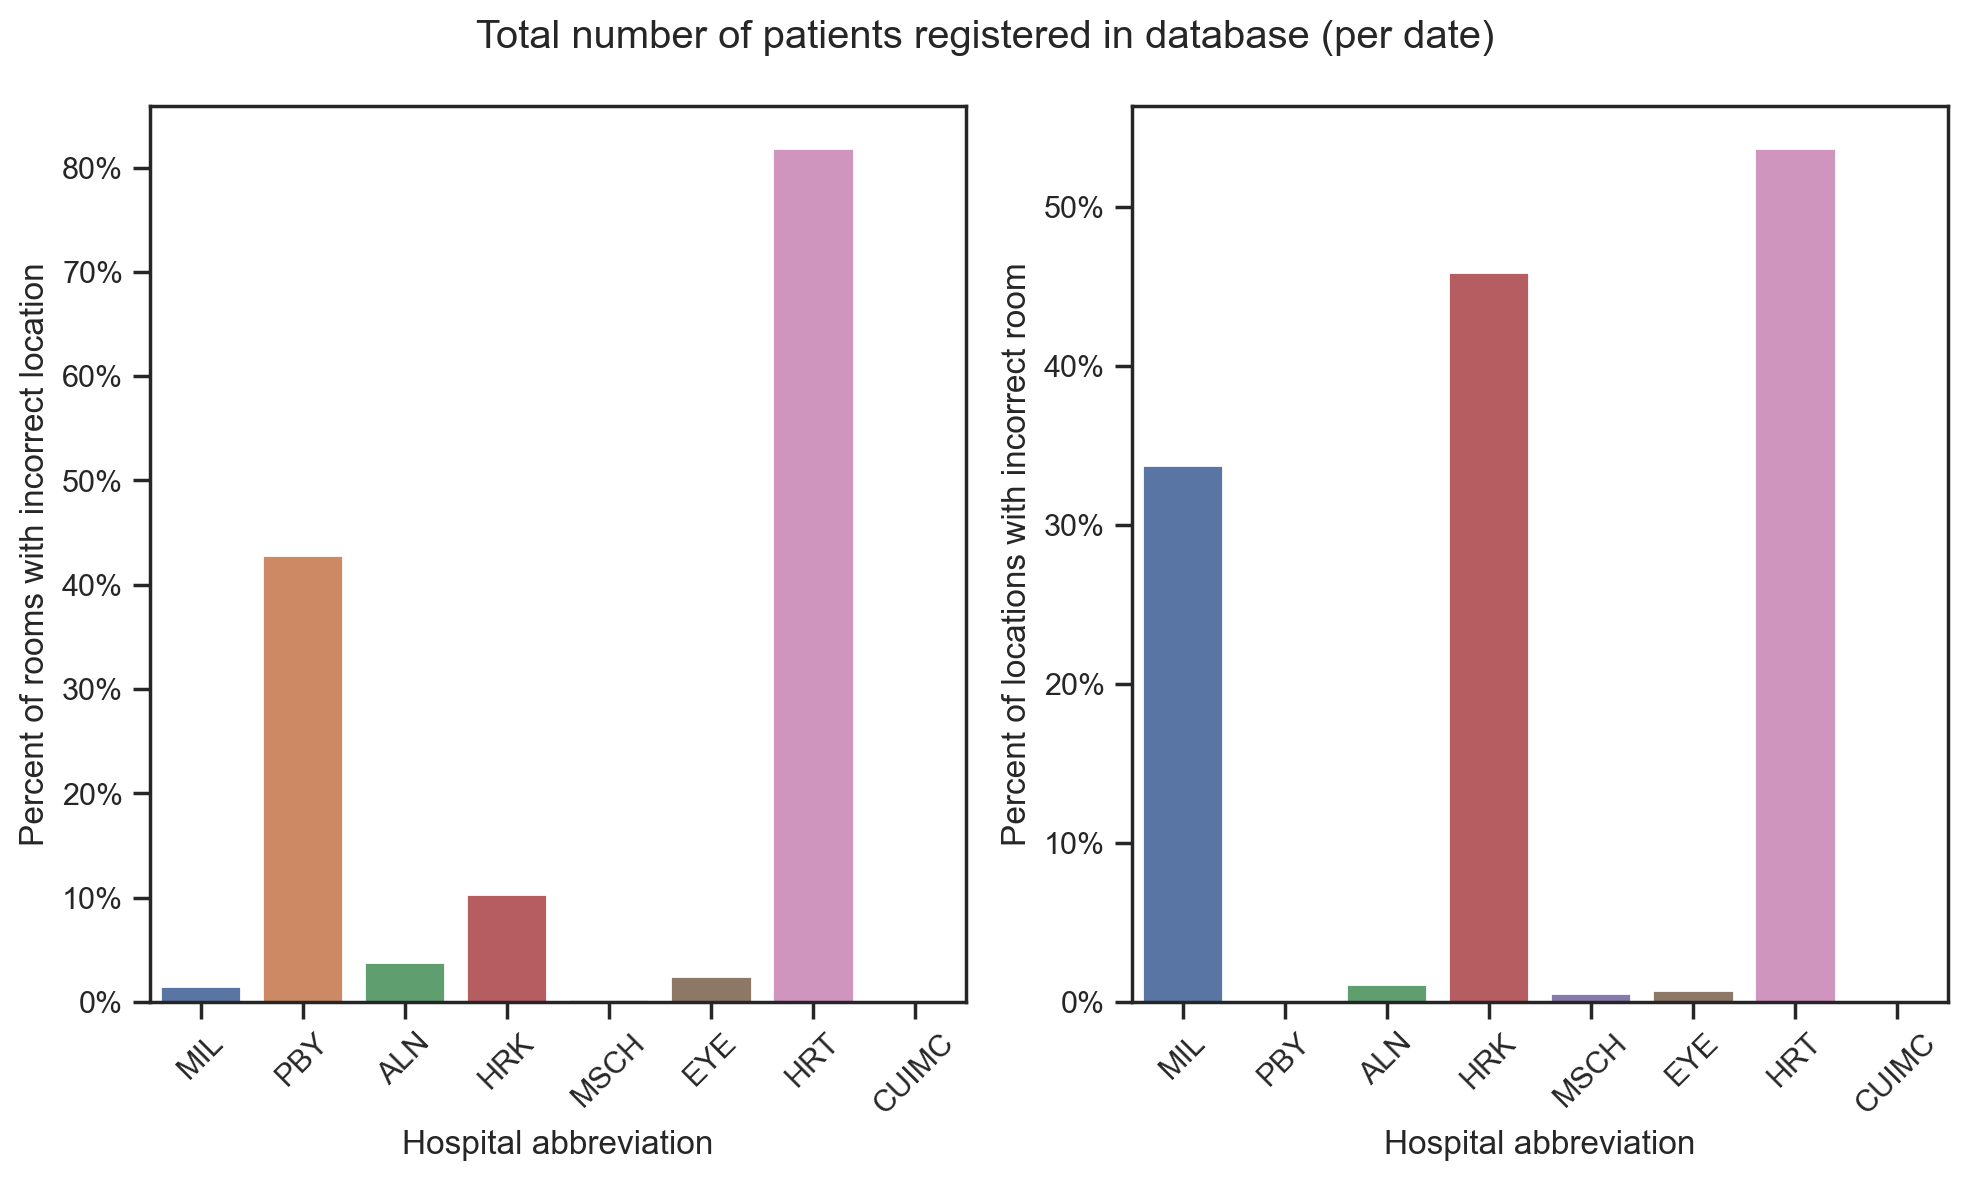

In [148]:
analysis_data = (data_abm
                 .filter((pl.col("room_recovered_name") != "HIP") & (pl.col("room_recovered_name") != "LAW") &
                         (pl.col("room_recovered_name") != "NYPW"))
                 .with_columns([
                     pl.col("room_recovered_name").str.replace("MIL/HC","MIL"),
                     pl.col("location_recovered_name").str.replace("MIL/HC","MIL")
                 ]))

total_registries = analysis_data.shape[0]
mismatch_registries = (analysis_data.filter(pl.col("room_recovered_name") != pl.col("location_recovered_name")))

#Total number of mismatchs
error = round(100*mismatch_registries.shape[0]/total_registries)

roomcounts = analysis_data.groupby("room_recovered_name", maintain_order=True).agg(pl.count())
mismatchcounts = mismatch_registries.groupby("room_recovered_name", maintain_order=True).agg(pl.count())

mismatched_rooms = (roomcounts
 .join(mismatchcounts,  on="room_recovered_name", how="left")
 .with_columns(
    (pl.col("count_right")/pl.col("count")).alias("percent")
 ))

#Get mismatched loctions
locatoncounts = analysis_data.groupby("location_recovered_name", maintain_order=True).agg(pl.count())
mismatchlocs = mismatch_registries.groupby("location_recovered_name", maintain_order=True).agg(pl.count())

mismatched_locations = (locatoncounts
 .join(mismatchlocs,  on="location_recovered_name", how="left")
 .with_columns(
    (pl.col("count_right")/pl.col("count")).alias("percent")
 ))


print(f"{mismatch_registries.shape[0]} ({error}%) registries have wrong room or location")

fig, ax =plt.subplots(1,2, figsize=(10, 6))
sns.barplot(data = mismatched_rooms.to_pandas(), x = "room_recovered_name", y = "percent", ax = ax[0])
ax[0].yaxis.set_major_formatter(mtick.PercentFormatter(xmax = 1))
ax[0].set_ylabel("Percent of rooms with incorrect location")
ax[0].set_xlabel("Hospital abbreviation")
ax[0].tick_params("x",labelrotation=45)

fig.suptitle('Total number of patients registered in database (per date)')

sns.barplot(data = mismatched_locations.to_pandas(), x = "location_recovered_name", y = "percent", ax = ax[1])
ax[1].yaxis.set_major_formatter(mtick.PercentFormatter(xmax = 1))
ax[1].set_ylabel("Percent of locations with incorrect room")
ax[1].set_xlabel("Hospital abbreviation")
ax[1].tick_params("x",labelrotation=45)

fig.tight_layout()
fig.show()

In [154]:
mismatch_registries

mrn,adt_care_level,adt_status,adt_location,adt_site,encounter_id,adt_event_type,adt_event_time,adt_ed_admission,adt_inpatient,adt_discharge,adt_discharge_disp,room_num,site_check,frequency,adt_site_name_std,adt_site_number_std,adt_discharge_disp_code,deceased_check,adt_event_date,room_8pm,hospital_block,hospital_block_8pm,event_type_order,latest_admission,latest_discharge,previous_adt_event_type,previous_adt_event_time,room_recovered_name,location_recovered_name,block_recovered_name
i64,str,str,str,str,i64,str,datetime[μs],datetime[μs],datetime[μs],datetime[μs],str,str,str,i64,str,i64,i64,datetime[μs],date,str,str,str,i32,date,date,str,datetime[μs],str,str,str
1000000400,"""Emergency""","""Emergency""","""MIL 7 HUDSON N…","""MILSTEIN HOSPI…",151871913,"""Admission""",2021-07-28 16:18:00,2021-07-28 16:18:00,2021-07-28 19:18:00,2021-08-07 15:09:00,"""Home-Health Ca…","""PBY ADULT EMER…","""MILSTEIN HOSPI…",355670,"""Columbia""",1,16,null,2021-07-28,"""PBY ADULT EMER…","""PBY ADULT EMER…","""PBY ADULT EMER…",-1,2021-07-28,2021-08-07,null,null,"""PBY""","""MIL""","""PBY"""
1000000400,"""Acute (Floor)""","""Acute (Floor)""","""MIL 7 HUDSON N…","""MILSTEIN HOSPI…",151871913,"""Patient Update…",2021-07-28 19:18:00,2021-07-28 16:18:00,2021-07-28 19:18:00,2021-08-07 15:09:00,"""Home-Health Ca…","""PBY ADULT EMER…","""MILSTEIN HOSPI…",355670,"""Columbia""",1,16,null,2021-07-28,"""PBY ADULT EMER…","""PBY ADULT EMER…","""PBY ADULT EMER…",0,2021-07-28,2021-08-07,"""Admission""",2021-07-28 16:18:00,"""PBY""","""MIL""","""PBY"""
1000000400,"""Acute (Floor)""","""Acute (Floor)""","""MIL 7 HUDSON N…","""MILSTEIN HOSPI…",151871913,"""Patient Update…",2021-07-28 19:21:00,2021-07-28 16:18:00,2021-07-28 19:18:00,2021-08-07 15:09:00,"""Home-Health Ca…","""PBY ADULT EMER…","""MILSTEIN HOSPI…",355670,"""Columbia""",1,16,null,2021-07-28,"""PBY ADULT EMER…","""PBY ADULT EMER…","""PBY ADULT EMER…",0,2021-07-28,2021-08-07,"""Patient Update…",2021-07-28 19:18:00,"""PBY""","""MIL""","""PBY"""
1000000400,"""Acute (Floor)""","""Acute (Floor)""","""MIL 7 HUDSON N…","""MILSTEIN HOSPI…",151871913,"""Census""",2021-07-28 23:59:00,2021-07-28 16:18:00,2021-07-28 19:18:00,2021-08-07 15:09:00,"""Home-Health Ca…","""PBY ADULT EMER…","""MILSTEIN HOSPI…",355670,"""Columbia""",1,16,null,2021-07-28,"""PBY ADULT EMER…","""PBY ADULT EMER…","""PBY ADULT EMER…",0,2021-07-28,2021-08-07,"""Patient Update…",2021-07-28 19:21:00,"""PBY""","""MIL""","""PBY"""
1000000400,"""Acute (Floor)""","""Acute (Floor)""","""MIL 7 HUDSON N…","""MILSTEIN HOSPI…",151871913,"""Transfer Out""",2021-07-29 01:06:00,2021-07-28 16:18:00,2021-07-28 19:18:00,2021-08-07 15:09:00,"""Home-Health Ca…","""PBY ADULT EMER…","""MILSTEIN HOSPI…",355670,"""Columbia""",1,16,null,2021-07-29,"""MIL 9 HUDSON S…","""PBY ADULT EMER…","""MIL 9 HUDSON N…",1,2021-07-28,2021-08-07,"""Census""",2021-07-28 23:59:00,"""PBY""","""MIL""","""PBY"""
1000000400,"""Emergency""","""Emergency""","""MIL 9 HUDSON""","""MILSTEIN HOSPI…",153954849,"""Admission""",2021-08-25 13:10:00,2021-08-25 13:10:00,2021-08-25 17:34:00,2021-08-30 18:36:00,"""Home-Health Ca…","""PBY ADULT EMER…","""MILSTEIN HOSPI…",355670,"""Columbia""",1,16,null,2021-08-25,"""PBY ADULT EMER…","""PBY ADULT EMER…","""PBY ADULT EMER…",-1,2021-08-25,2021-08-30,"""Discharge""",2021-08-07 15:09:00,"""PBY""","""MIL""","""PBY"""
1000000400,"""Emergency""","""Emergency""","""MIL 9 HUDSON""","""MILSTEIN HOSPI…",153954849,"""Transfer In""",2021-08-25 14:21:00,2021-08-25 13:10:00,2021-08-25 17:34:00,2021-08-30 18:36:00,"""Home-Health Ca…","""PBY ADULT EMER…","""MILSTEIN HOSPI…",355670,"""Columbia""",1,16,null,2021-08-25,"""PBY ADULT EMER…","""PBY ADULT EMER…","""PBY ADULT EMER…",-1,2021-08-25,2021-08-30,"""Admission""",2021-08-25 13:10:00,"""PBY""","""MIL""","""PBY"""
1000000400,"""Emergency""","""Emergency""","""MIL 9 HUDSON""","""MILSTEIN HOSPI…",153954849,"""Transfer Out""",2021-08-25 14:21:00,2021-08-25 13:10:00,2021-08-25 17:34:00,2021-08-30 18:36:00,"""Home-Health Ca…","""P

## Room sizes
Calculate the sizes of each room

<Figure size 640x480 with 0 Axes>

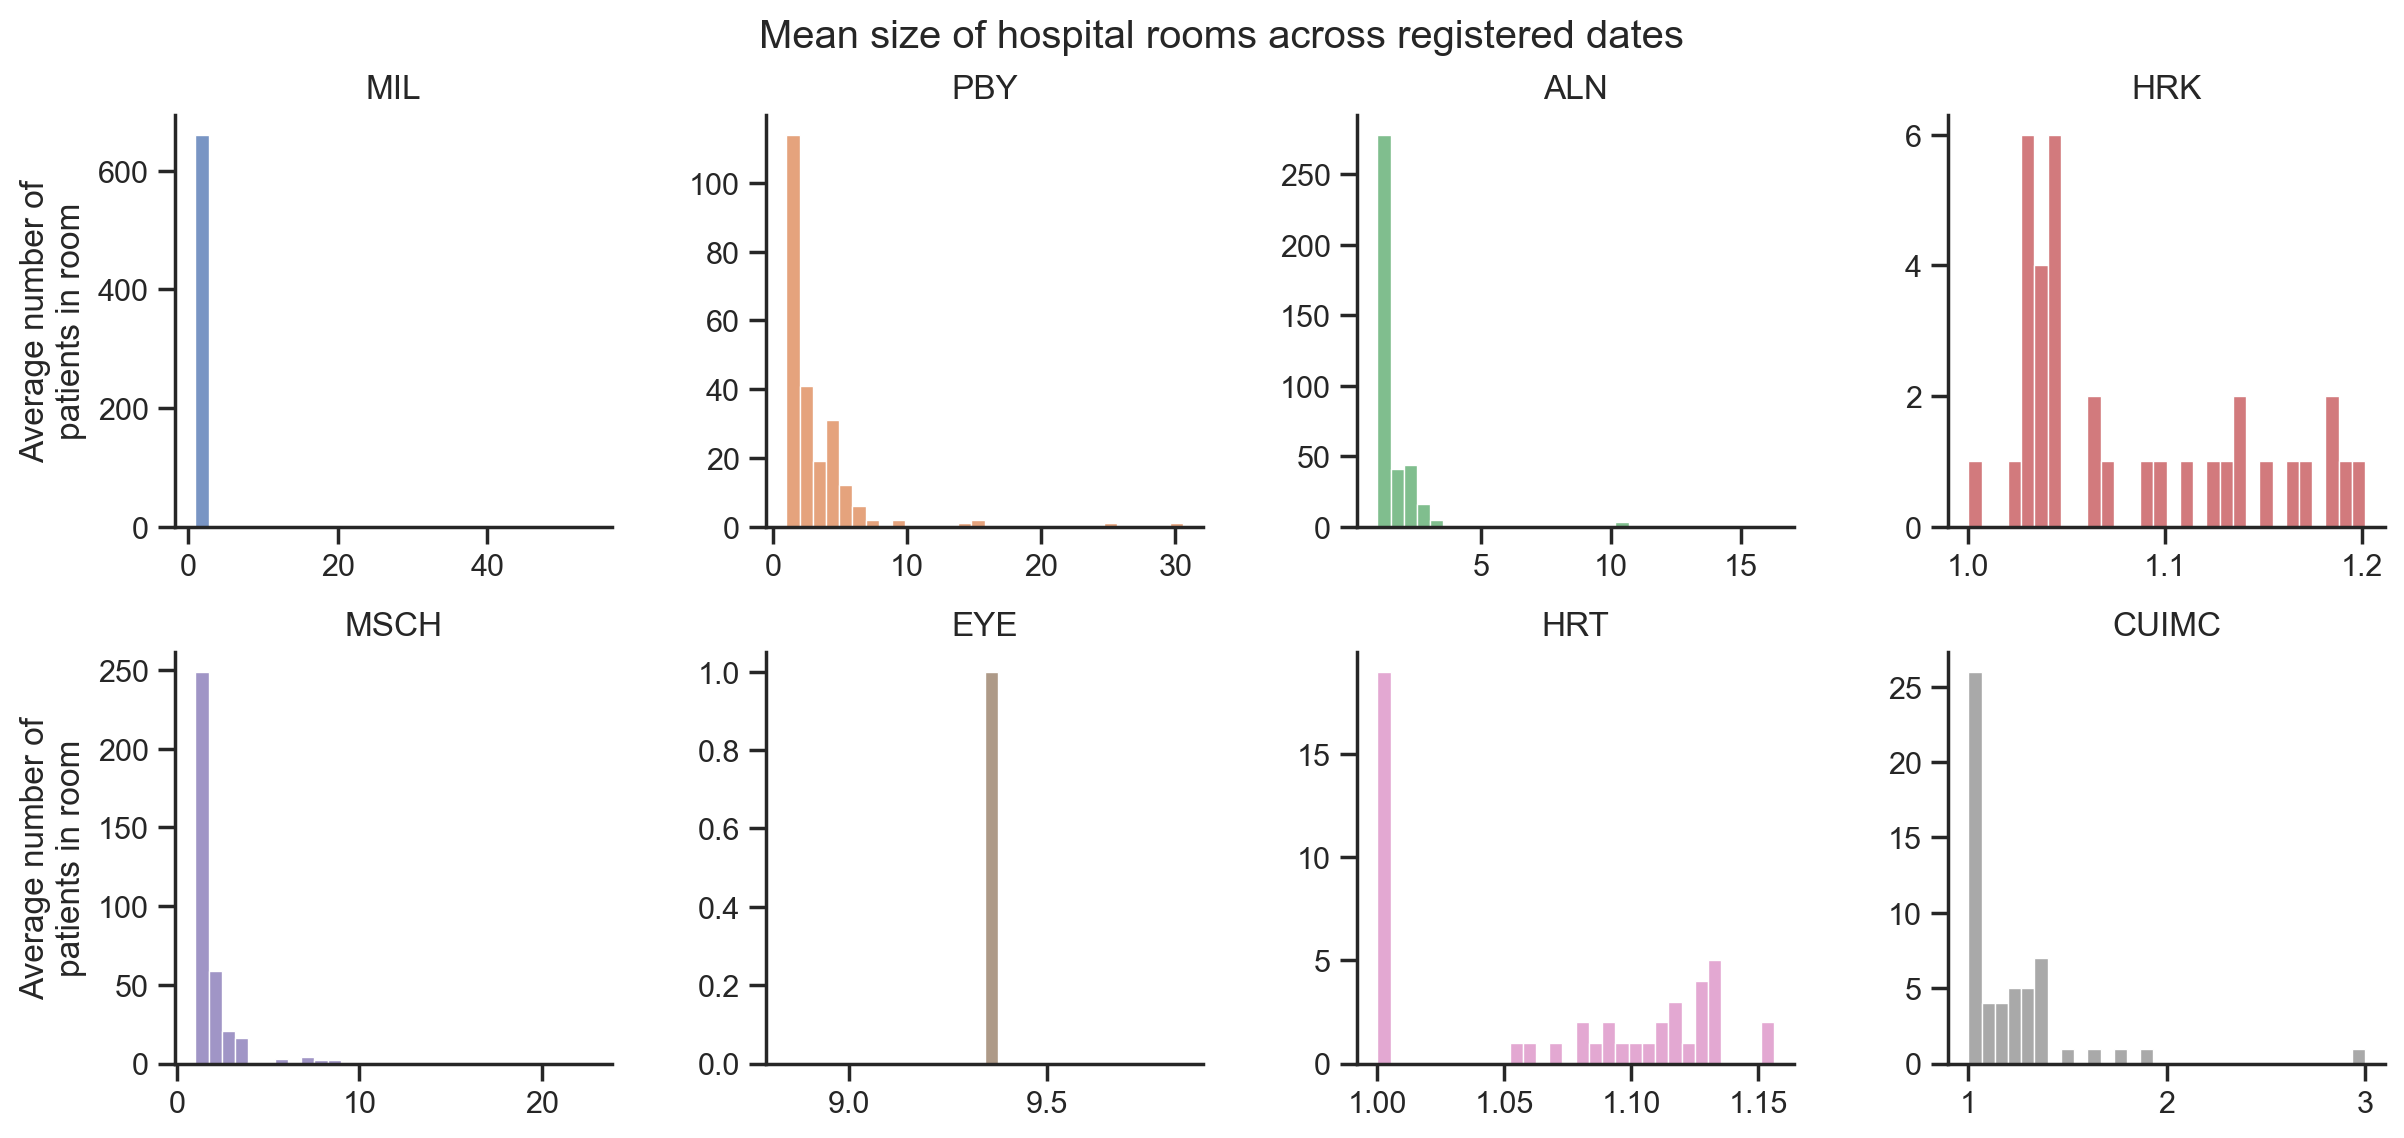

In [141]:
rooms = (analysis_data
         .unique(subset=["mrn", "adt_event_date","room_num","room_recovered_name"], keep="first", maintain_order=True)
         .groupby(["adt_event_date","room_num","room_recovered_name"], maintain_order=True)
         .agg(pl.count()))

roomplot = (rooms
         .groupby(["room_num","room_recovered_name"], maintain_order=True)
         .agg(pl.mean("count")))

# Plot by hospital
plt.figure()
g = sns.FacetGrid(roomplot.to_pandas(), col="room_recovered_name", hue="room_recovered_name", col_wrap=4, sharey=False, sharex=False)
g.map(sns.histplot, "count", bins=30)
g.set_axis_labels("", "Average number of\npatients in room")
g.set_titles(col_template="{col_name}", row_template="{row_name}")
g.fig.subplots_adjust(top=.9)
g.fig.suptitle('Mean size of hospital rooms across registered dates')
plt.show()

#Save as csv
rooms.to_pandas().to_csv("roomsize.csv")

::: {.callout-tip title="Actions"}
### Suggested course of action
+ Verify the data structure with data providers to decide which one is the correct `room`-`ward`-`hospital` trio. 
:::

# Resurrection check

We verify that no individuals are present in the registry after their time of death (`deceased_check`). 

In [36]:
resurrected = data_abm.filter(
    pl.Expr.is_not_null(pl.col("deceased_check")) & 
    (pl.col("adt_event_time") - pl.col("deceased_check") > dt.timedelta(days = 0)))

if (resurrected.shape[0] > 0):
    print(f"❌ {resurrected.shape[0]} deceased individuals reappear later on the dataset")
else:
    print(f"✅ All registries from deceased individuals remain deceased")

✅ All registries from deceased individuals remain deceased


# Session info

In [37]:
session_info.show(html=False)

-----
matplotlib          3.7.1
matplotlib_inline   0.1.6
numpy               1.24.4
pandas              2.0.3
polars              0.18.4
seaborn             0.12.2
session_info        1.0.0
-----
IPython             8.14.0
jupyter_client      7.4.1
jupyter_core        5.3.1
jupyterlab          3.6.5
notebook            6.5.4
-----
Python 3.9.16 | packaged by conda-forge | (main, Feb  1 2023, 21:42:20) [Clang 14.0.6 ]
macOS-13.2.1-x86_64-i386-64bit
-----
Session information updated at 2023-07-06 21:43
